In [ ]:
import os
import cv2
import glob
import torch
import datetime
import numpy as np
from PIL import Image
import torch.nn as nn
import albumentations as A
from torch import from_numpy
import torch.nn.functional as F
from torch.nn import DataParallel
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader

In [ ]:
!gdown -O cityscape128.zip "https://drive.google.com/u/0/uc?id=1XUWaL2ijz1vjbKbxJ6TYkG4QZgIsiZu_&export=download"

Downloading...
From: https://drive.google.com/u/0/uc?id=1XUWaL2ijz1vjbKbxJ6TYkG4QZgIsiZu_&export=download
To: /content/cityscape128.zip
100% 50.1M/50.1M [00:01<00:00, 37.4MB/s]


In [ ]:
!unzip cityscape128.zip

Streaming output truncated to the last 5000 lines.
  inflating: segdata128/reduced_mask/train/1114.jpg  
  inflating: segdata128/reduced_mask/train/294.jpg  
  inflating: segdata128/reduced_mask/train/886.jpg  
  inflating: segdata128/reduced_mask/train/1816.jpg  
  inflating: segdata128/reduced_mask/train/1187.jpg  
  inflating: segdata128/reduced_mask/train/1723.jpg  
  inflating: segdata128/reduced_mask/train/312.jpg  
  inflating: segdata128/reduced_mask/train/2565.jpg  
  inflating: segdata128/reduced_mask/train/1232.jpg  
  inflating: segdata128/reduced_mask/train/2628.jpg  
  inflating: segdata128/reduced_mask/train/2630.jpg  
  inflating: segdata128/reduced_mask/train/2744.jpg  
  inflating: segdata128/reduced_mask/train/1149.jpg  
  inflating: segdata128/reduced_mask/train/1026.jpg  
  inflating: segdata128/reduced_mask/train/1354.jpg  
  inflating: segdata128/reduced_mask/train/989.jpg  
  inflating: segdata128/reduced_mask/train/487.jpg  
  inflating: segdata128/reduced_mask

In [ ]:
# Data path
INPUT_PATH = './segdata128/reduced'
INPUT_PATH_MASK = './segdata128/reduced_mask'

## Parameters

In [ ]:
INPUT_IMG_SIZE = 128

OUTPUT_CLASSES = 12

LEARINING_RATE = 0.01

OPIMIZER_NAME = 'Adam'

SCHEDULER_NAME = 'stepLR'

BATCH_SIZE = 8

MAX_EPOCHS = 10

AUGMENTATION = False

MEAN = None

STD = None

THRESH_ACC_CKP = 0.9

SCHEDULER_STEP_SIZE = 4

USE_CUDA = torch.cuda.is_available()

## Data preprocessing

In [ ]:
train_files = glob.glob(os.path.join(INPUT_PATH + '/train', '*jpg'))
train_files_mask = glob.glob(os.path.join(INPUT_PATH_MASK + '/train', '*jpg'))
test_files = glob.glob(os.path.join(INPUT_PATH + '/val', '*jpg'))
test_files_mask = glob.glob(os.path.join(INPUT_PATH_MASK + '/val', '*jpg'))

print('Total train images:', len(train_files))

print('Total train mask:', len(train_files_mask))

print('Total test images:', len(test_files))
print('Total test mask:', len(test_files_mask))



Total train images: 2975
Total train mask: 2975
Total test images: 500
Total test mask: 500


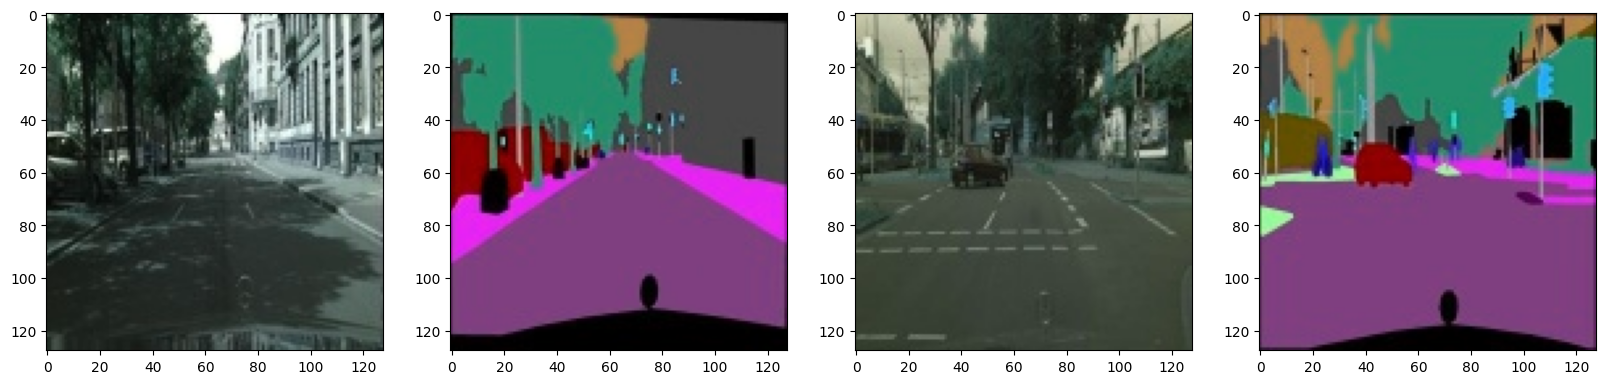

In [ ]:
fig, axes = plt.subplots(1,4, figsize = (20,5))
for i, ax in enumerate(axes.ravel()):
    if(i%2==0):
      img = cv2.imread(train_files[i//2])
      ax.imshow(img)
    else:
      mk = cv2.imread(train_files_mask[i//2])
      ax.imshow(mk)
    # break
    #ax.axis('off')
plt.show()

### As you can observe:

*  Masks are in the RGB format
*  The Number of segmented classes is changing in every mask (non uniform class number in the label data).
*  Masks are not encoded

### Preparation:

*  Using Kmeans algorithm --> clustering the unique colors present in a mask
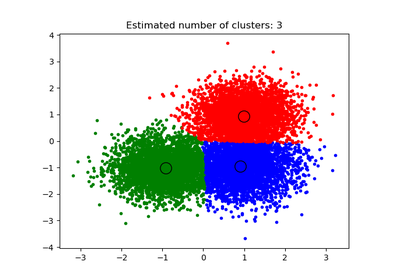

*  Use trained Kmeans to encode RGB mask as color encoded mask

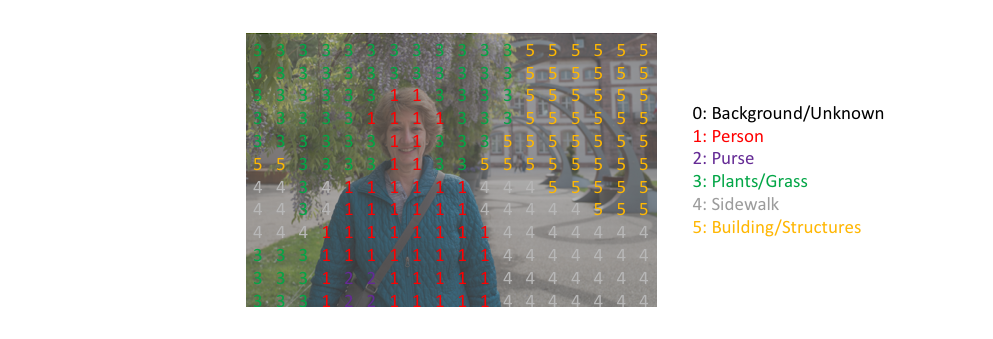

*  As illustated in the above example, every object in that image has been encoded with a specific number
*  We are also doing the same thing by using kmeans

## Mask encoding

* **bold text** We are going to use 50 masks as training data for clustering
* (50, 256, 256, 3) --> (50 x 256 x 256, 3) --> (3276800, 3)
* We have 3276800 data points (3 --> RGB values) for clustering
* Using 12 kmeans clusters

In [ ]:
kmeans_data = []
for i in train_files_mask[:50]:
    org_img = cv2.imread(i)

    msk = org_img
    kmeans_data.append(msk)
kmeans_data = np.array(kmeans_data)
kmeans_data = kmeans_data.reshape(-1,3)
print(kmeans_data.shape)

(819200, 3)


In [ ]:
# train kmeans with 12 clusters
encoder = KMeans(n_clusters=OUTPUT_CLASSES)
encoder.fit(kmeans_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=12)

In [ ]:
encoder.cluster_centers_

array([[220.248656  ,  42.09716924, 231.72747552],
       [ 41.90475067, 138.67337065, 107.6073873 ],
       [ 67.05998601,  70.76321598,  70.72120708],
       [  6.2163142 ,   4.85172205,   6.72602719],
       [127.39392823,  63.59995683, 128.0910133 ],
       [135.65972928,   2.10306586,   4.95794034],
       [131.79637829, 179.1046208 , 176.77997275],
       [165.42782536, 125.24844072,  81.3466233 ],
       [ 63.11303421,  29.89213354, 193.65556558],
       [171.67121835, 162.76773167, 231.03605992],
       [ 94.1635666 ,  55.96446743,  13.69630495],
       [ 68.80228089,  15.25185897,  86.52067842]])

In [ ]:
# If you have previous knowledge about the colors to be used for the classes
colors = {0: [255,0,0],
          1: [0,255,0],
          2: [0,0,255],
          3: [255,69,0],
          4: [255,0,255],
          5: [210,105,30],
          6: [192,255,62],
          7: [127,255,0],
          8: [0,238,238],
          9: [72,118,255],
          10: [72,255,255],
          11: [255,118,255]
          }

In [ ]:
colors = {0:[ 42.31849768, 138.68802268, 107.34976084],
       1:[127.04043101,  64.08636608, 127.54335584],
       2:[ 67.73835184,  70.81071668,  69.68390725],
       3:[ 77.50990865,  18.95552339,  73.79703489],
       4:[133.96612288,   3.85362098,   4.37284647],
       5:[217.97385828,  43.76697629, 229.43543734],
       6:[164.94309451, 125.22840326,  81.50394562],
       7:[157.10134385, 155.26893603, 193.22678809],
       8:[ 66.53429189,  32.62107138, 188.45387454],
       9:[157.58165138, 243.49941618, 159.97381151],
       10:[  6.98127537,   5.22420501,   6.82420501],
       11:[ 48.88183862, 203.80514614, 203.66699975]
          }

No of classes in encoded mask: [ 0  1  2  3  4  5  6  7  9 10 11]


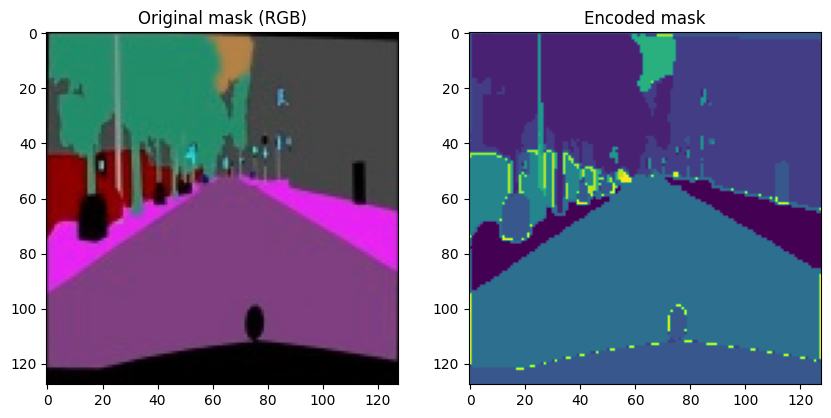

No of classes in encoded mask: [ 0  1  2  3  4  5  6  7  8  9 10 11]


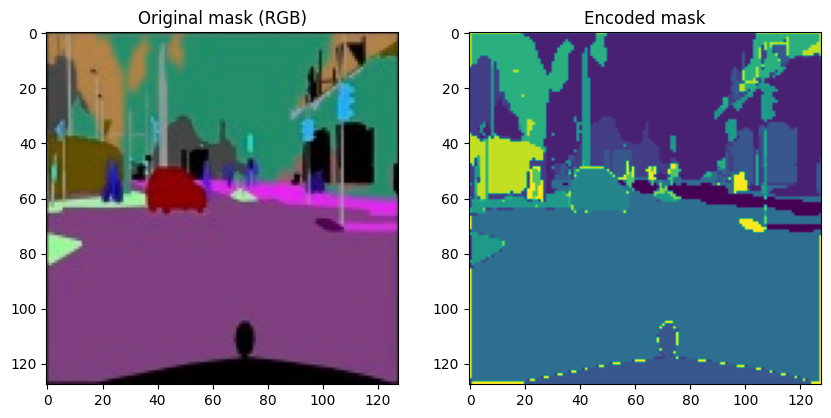

No of classes in encoded mask: [ 0  1  2  3  4  5  6  7  8  9 10 11]


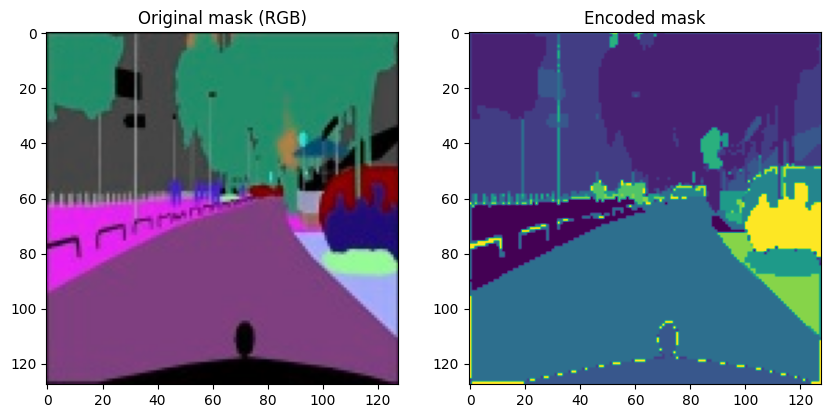

In [ ]:
# encoding with trained kmeans
for i in train_files[:3]:
    org_img = cv2.imread(i)
    #img = org_img[:, 0:256,:]
    msk = cv2.imread(i.replace("reduced","reduced_mask"))#org_img[:, 256:,:]      #shape (256,256,3)
    test = msk.reshape(-1,3)      #shape (65536,3)
    pred = encoder.predict(test)  #shape (65536)

    enc_pred = pred.reshape(INPUT_IMG_SIZE,INPUT_IMG_SIZE)  #shape (256,256)

    pred = np.array([colors[p] for p in pred]).reshape(INPUT_IMG_SIZE,INPUT_IMG_SIZE,3)

    print('No of classes in encoded mask:',np.unique(enc_pred))

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(msk)
    plt.title('Original mask (RGB)')
    plt.subplot(1,2,2)
    plt.imshow(enc_pred)
    plt.title('Encoded mask')
    plt.show()

## Load dataset

In [ ]:
class Dataset(Dataset):
    def __init__(self, images_list,mask_list, size, augmentation = False, mean = None, std = None):
        self.images_list = images_list
        self.mask_list = mask_list
        self.size = size
        self.augmentation = augmentation
        if mean is None or std is None:
            self.mean = [0., 0., 0.]
            self.std = [1., 1., 1.]
        else:
            self.mean = mean
            self.std = std

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, index):
        pil_image = Image.open(self.images_list[index]).convert('RGB')
        pil_mask = Image.open(self.mask_list[index]).convert('RGB')



        np_image = np.array(pil_image)
        np_target = np.array(pil_mask)


        test = (np_target.reshape(-1,3))
        pred = encoder.predict(test)
        seg_msk = pred.reshape(self.size,self.size)

        if self.augmentation:
            trans_obj = A.Compose([A.Resize(self.size, self.size),
                           A.Rotate(10, border_mode=4, p=0.5),
                           A.HorizontalFlip(p=0.3),
                           A.VerticalFlip(p=0.3),
                           A.OneOf([A.OpticalDistortion(),A.ElasticTransform()],  p=0.4),
                           A.CoarseDropout(max_holes=30, max_height=int(self.size*0.015),
                                         max_width=int(self.size*0.015), fill_value=255, p=0.4),
                           A.RandomBrightnessContrast(brightness_limit=0.3,p = 0.4),
                           A.RandomSnow(snow_point_lower=0.4,snow_point_upper=0.5,brightness_coeff=1.5,p = 0.4),
                           A.Normalize(self.mean, self.std)
                          ])
        else:
            trans_obj = A.Compose([A.Resize(self.size, self.size),
                                   A.Normalize(self.mean, self.std)])

        transformed = trans_obj(image = np_image, mask = seg_msk)
        img_tensor = from_numpy(transformed['image']).permute(2, 0, 1)
        mask_tensor = from_numpy(transformed['mask'])
        return img_tensor, mask_tensor


In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=256, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)




    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):

        contracting_11_out = self.contracting_11(X)

        contracting_12_out = self.contracting_12(contracting_11_out)

        contracting_21_out = self.contracting_21(contracting_12_out)

        contracting_22_out = self.contracting_22(contracting_21_out)

        contracting_31_out = self.contracting_31(contracting_22_out)

        contracting_32_out = self.contracting_32(contracting_31_out)

        middle_out = self.middle(contracting_32_out)

        expansive_11_out = self.expansive_11(middle_out)

        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_31_out), dim=1))

        expansive_21_out = self.expansive_21(expansive_12_out)

        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_21_out), dim=1))

        expansive_31_out = self.expansive_31(expansive_22_out)

        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_11_out), dim=1))

        output_out = self.output(expansive_32_out)
        return output_out

In [ ]:
nt = Net(12)

In [ ]:
nt(torch.zeros(2,3,128,128)).shape

torch.Size([2, 12, 128, 128])

## Trainer

In [ ]:
import tqdm
class Trainer:
    def __init__(self,
                 model,                          # Model to be trained.
                 crit,                           # Loss function
                 train_data = None,              # Training data set
                 val_data = None,                # Validation (or test) data set
                 initialize_from_ckp = None,     # If you want to continue training from a specific checkpoint
                 opti_name = None,
                 scheduler_name = None,
                 input_img_size = None,
                 batch_size = None,
                 out_classes = None,
                 use_cuda = False,
                 max_epochs = None,
                 learning_rate = None,
                 thresh_acc = None,
                 experiment_name = None,
                 step_size = None
                 ):
        self.model = model
        self.crit = crit
        self.train_data = train_data
        self.val_data = val_data
        self.opti_name = opti_name
        self.scheduler_name = scheduler_name
        self.input_img_size = input_img_size
        self.batch_size = batch_size
        self.out_classes = out_classes
        self.cuda = use_cuda
        self.max_epochs = max_epochs
        self.learning_rate = learning_rate
        self.thresh_acc_ckp = thresh_acc
        self.step_size = step_size

        if use_cuda:
            self.model = model.cuda()
            self.crit = crit.cuda()
            self.model = DataParallel(model)

        self.optim = self.select_optimizer()
        self.scheduler = self.select_scheduler()
        self.train_dl = self.data_loader(self.train_data)
        self.val_test_dl = self.data_loader(self.val_data)
        self.nowtime = datetime.datetime.now().strftime('%d-%m-%Y [%H.%M.%S]')

        if initialize_from_ckp is not None:
            self.restore_checkpoint(initialize_from_ckp)

    def data_loader(self, data_object):
        return DataLoader(data_object, batch_size = self.batch_size, shuffle=True)

    def select_optimizer(self):
        if self.opti_name == 'Adam':
            return Adam(self.model.parameters(), lr=self.learning_rate)
        if self.opti_name == 'SGD':
            return SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.9)

    def select_scheduler(self):
        if self.scheduler_name == 'stepLR':
            return lr_scheduler.StepLR(optimizer=self.optim, step_size = self.step_size, gamma=0.1)
        if self.scheduler_name == 'ReduceLROnPlateau':
            return lr_scheduler.ReduceLROnPlateau(optimizer = self.optim, mode='max', factor=0.2)

    def restore_checkpoint(self, checkpoint):
        cuda_device = torch.device('cuda' if self.cuda else 'cpu')
        ckp = torch.load(checkpoint, map_location = cuda_device)
        self.model.load_state_dict(ckp)
        for param in self.model.features.parameters():
            param.requires_grad = False
        # self._optim.load_state_dict(ckp)

    def save_checkpoint(self, folder_name):
        torch.save({'state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optim.state_dict(),
                }, folder_name + '/checkpoint.ckp')

    def IoU(self, label, pred, num_classes=12):
        label = label.detach().cpu()
        pred = pred.detach().cpu()
        pred = F.softmax(pred, dim=1)
        pred = torch.argmax(pred, dim=1).squeeze(1)
        iou_list = list()
        present_iou_list = list()

        pred = pred.view(-1)
        label = label.view(-1)
        # Note: Following for loop goes from 0 to (num_classes-1)
        # and ignore_index is num_classes, thus ignore_index is
        # not considered in computation of IoU.
        for sem_class in range(num_classes):
            pred_inds = (pred == sem_class)
            target_inds = (label == sem_class)
            if target_inds.long().sum().item() == 0:
                iou_now = float('nan')
            else:
                intersection_now = (pred_inds[target_inds]).long().sum().item()
                union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
                iou_now = float(intersection_now) / float(union_now)
                present_iou_list.append(iou_now)
            iou_list.append(iou_now)
        return np.mean(present_iou_list)

    def train_epoch(self):
        device = torch.device('cuda' if self.cuda else 'cpu')
        self.model.train()
        loss_list = []
        acc_list = []

        for i, (images, labels) in enumerate(self.train_dl):
            batchsize = images.shape[0]
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)
            self.optim.zero_grad()
            preds = self.model(images)
            loss = self.crit(preds, labels.long())
            accuracy = self.IoU(labels, preds)
            #print(accuracy)
            loss.backward()
            self.optim.step()
            lossitem = loss.item()
            del loss  # this may be the fix for my OOM error
            loss_list.append(lossitem)
            acc_list.append(accuracy)

        loss_avg = np.mean(loss_list)
        acc_avg = np.mean(acc_list)
        return loss_avg, acc_avg

    def val_epoch(self, current_epoch):
        device = torch.device('cuda' if self.cuda else 'cpu')
        self.model.eval()
        loss_list = []
        acc_list = []
        with torch.no_grad():
            for i, (images, labels) in enumerate(self.val_test_dl):
                im, lb = images, labels
                batchsize = images.shape[0]
                images = images.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)
                preds = self.model(images)
                loss = self.crit(preds, labels.long())
                lossitem = loss.item()
                del loss

                accuracy = self.IoU(labels, preds)
                loss_list.append(lossitem)
                acc_list.append(accuracy)
                if i == 2:
                    print('-'*20)
                    print('Validation results after {} epochs:'.format(current_epoch))
                    plt.figure(figsize=(20,15))
                    plt.subplot(1,3,1)
                    plt.imshow(im[0].permute(1,2,0))
                    plt.title('image')
                    plt.subplot(1,3,2)
                    plt.imshow(lb[0])
                    plt.title('mask')
                    plt.subplot(1,3,3)
                    p = preds[0].permute(1,2,0)
                    p = torch.argmax(p, dim=2)
                    plt.imshow(p.cpu())
                    plt.title('pediction')
                    plt.show()
            loss_avg = np.mean(loss_list)
            acc_avg = np.mean(acc_list)
        return loss_avg, acc_avg

    def print_train_logs(self, results):
        epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy = results
        print('[Epochs-{}/{}]:'. format(epoch_counter, self.max_epochs))
        print('[Train_loss:{:0.4f} | Train_acc:{:0.4f} | Val_loss:{:0.4f} | Val_acc:{:0.4f}]'
                  .format(train_loss, train_accuracy, val_loss, val_accuracy))

    def plot_logs(self, results):
        epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy = results
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.plot(epoch_counter, train_accuracy)
        plt.plot(epoch_counter, val_accuracy)
        plt.title('acc')
        plt.subplot(1,2,2)
        plt.plot(epoch_counter, train_loss)
        plt.plot(epoch_counter, val_loss)
        plt.title('loss')
        plt.show()

    def train(self):

        model_path = 'results/%s' % (self.nowtime)
        epoch_counter_list = []
        train_loss_list = []
        train_accuracy_list = []
        val_loss_list = []
        val_accuracy_list = []

        for epoch_counter in tqdm.tqdm(range(1, self.max_epochs+1)):
            train_loss, train_accuracy = self.train_epoch()
            val_loss, val_accuracy= self.val_epoch(epoch_counter)
            epoch_counter_list.append(epoch_counter)
            train_loss_list.append(train_loss)
            train_accuracy_list.append(train_accuracy)
            val_loss_list.append(val_loss)
            val_accuracy_list.append(val_accuracy)
            epoch_results = [epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy]
            self.print_train_logs(epoch_results)

            if val_accuracy > self.thresh_acc_ckp and val_accuracy == max(val_accuracy_list):
                new_ckp = '/epoch_{}_val_acc [{:0.3f}]' . format(epoch_counter, val_accuracy)
                temp_path = model_path + new_ckp
                os.makedirs(temp_path, exist_ok=True)
                if os.path.exists(temp_path):
                    self.save_checkpoint(temp_path)

            if self.scheduler:
                self.scheduler.step()
        train_results = [epoch_counter_list, train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list]
        #self.plot_logs(train_results)

## Create dataset objects

In [ ]:
train_data_obj = Dataset(train_files,train_files_mask, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)
val_data_obj = Dataset(test_files, test_files_mask, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)

In [ ]:
print(train_data_obj.__len__())
print(val_data_obj.__len__())

2975
500


## Data visualization

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.) tensor(0.)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


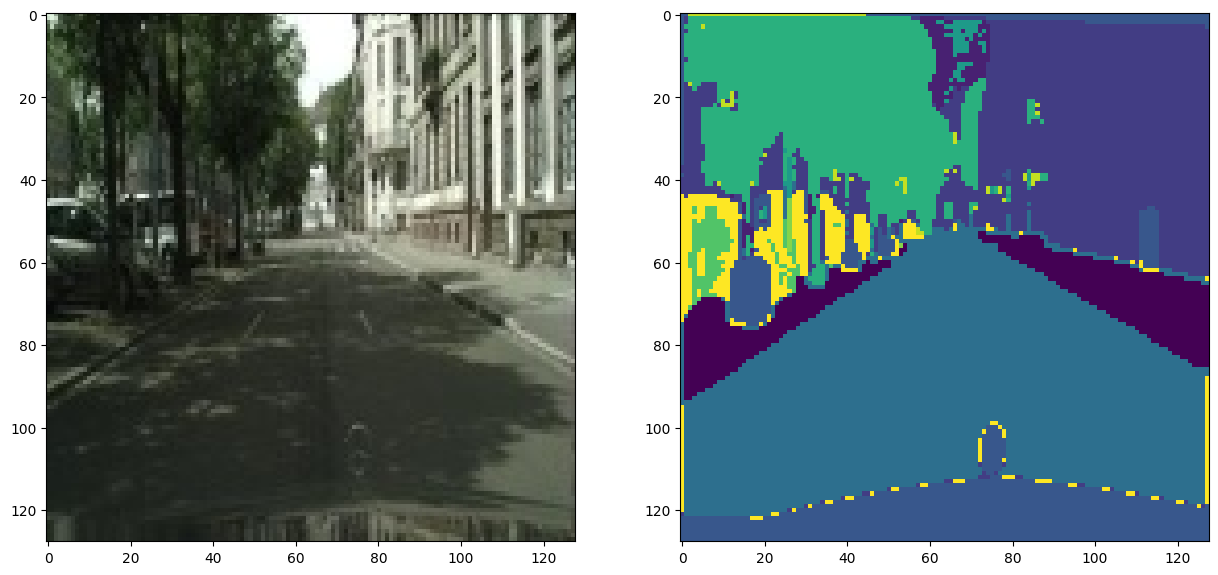

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(0.9412) tensor(0.0235)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


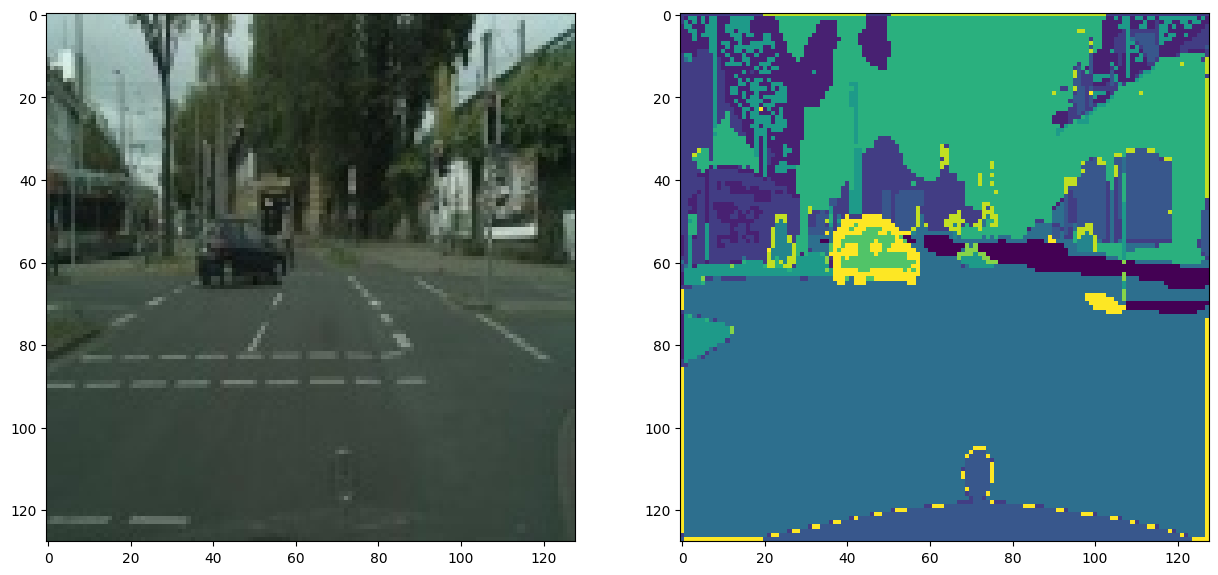

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.) tensor(0.0157)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


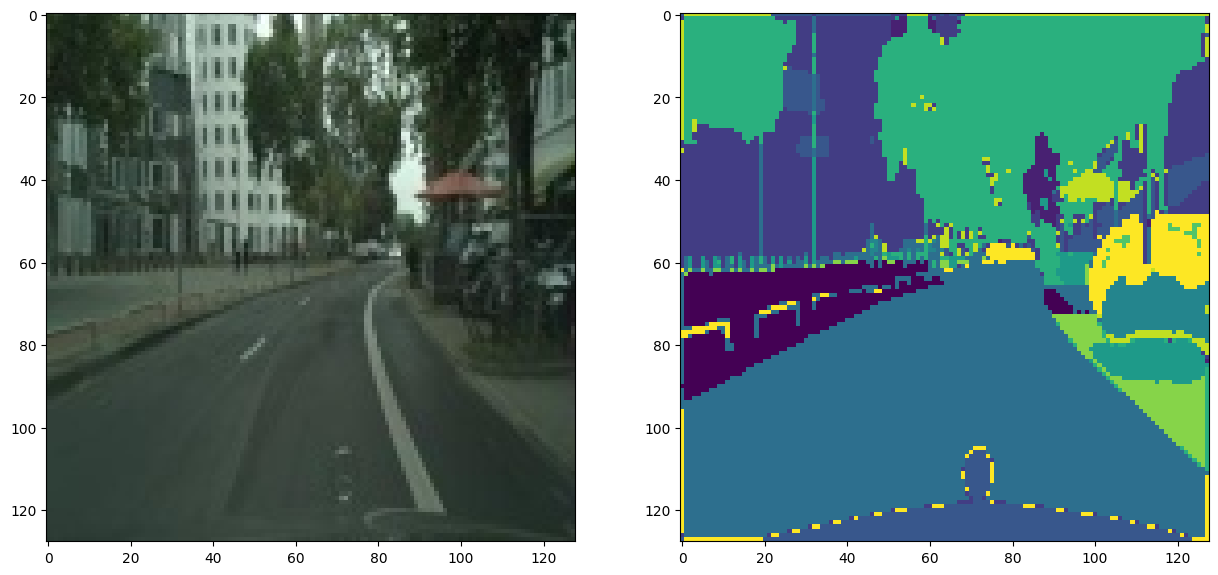

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(0.9373) tensor(0.0196)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


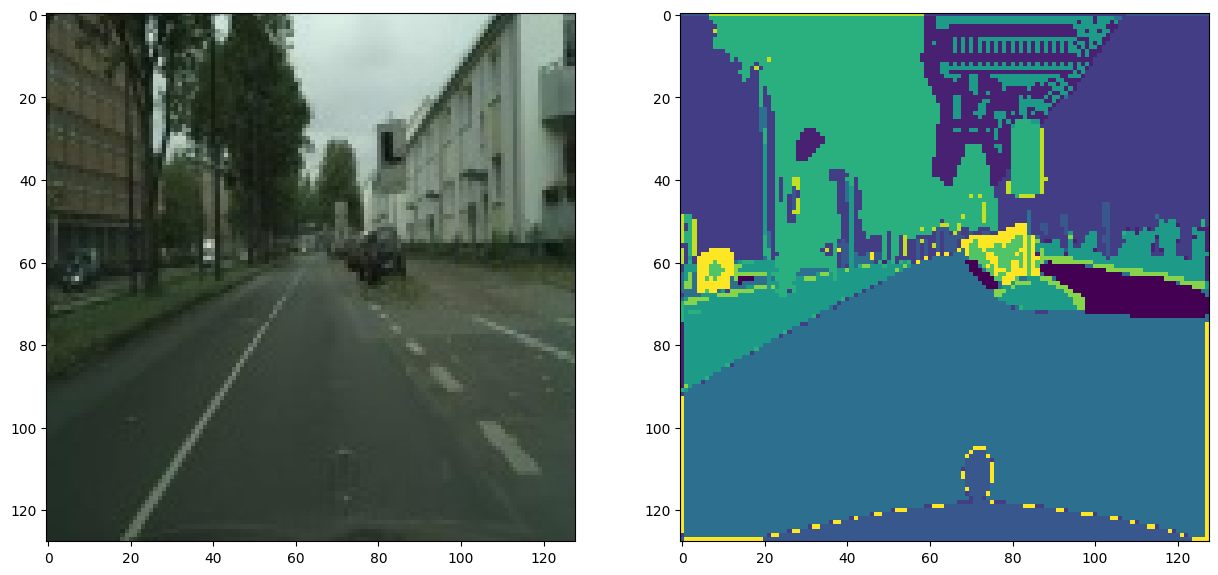

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.) tensor(0.0118)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


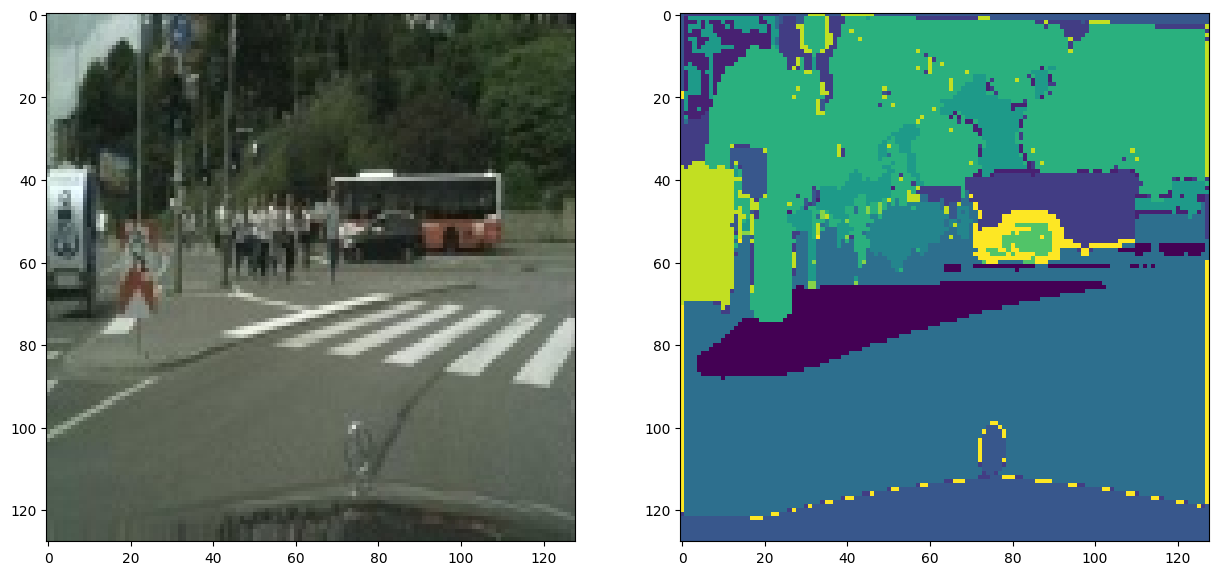

In [ ]:
for i in range(5):
    img,  msk = train_data_obj.__getitem__(i)
    print(img.shape, msk.shape)
    print(img.max(), img.min())
    print(msk.max(), msk.min())
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(img.permute(1,2,0))
    plt.subplot(1,2,2)
    plt.imshow(msk)
    plt.show()

## Define models

In [ ]:
unet = Net(num_classes=OUTPUT_CLASSES)

## No of trainable parameters

In [ ]:
print(sum(p.numel() for p in unet.parameters()))

18010252


## Define loss function

In [ ]:
model = unet
loss_function = nn.CrossEntropyLoss()

## Define trainer object

In [ ]:
trainer =  Trainer(model = model,
                  crit = loss_function,
                  train_data = train_data_obj,
                  val_data = val_data_obj,
                  initialize_from_ckp = None,
                  opti_name = OPIMIZER_NAME,
                  scheduler_name = SCHEDULER_NAME,
                  input_img_size = INPUT_IMG_SIZE,
                  batch_size = BATCH_SIZE,
                  out_classes = OUTPUT_CLASSES,
                  use_cuda = USE_CUDA,
                  max_epochs = MAX_EPOCHS,
                  learning_rate = LEARINING_RATE,
                  thresh_acc = THRESH_ACC_CKP,
                  step_size = SCHEDULER_STEP_SIZE
                 )

## Start training

  0%|          | 0/10 [00:00<?, ?it/s]

--------------------
Validation results after 1 epochs:


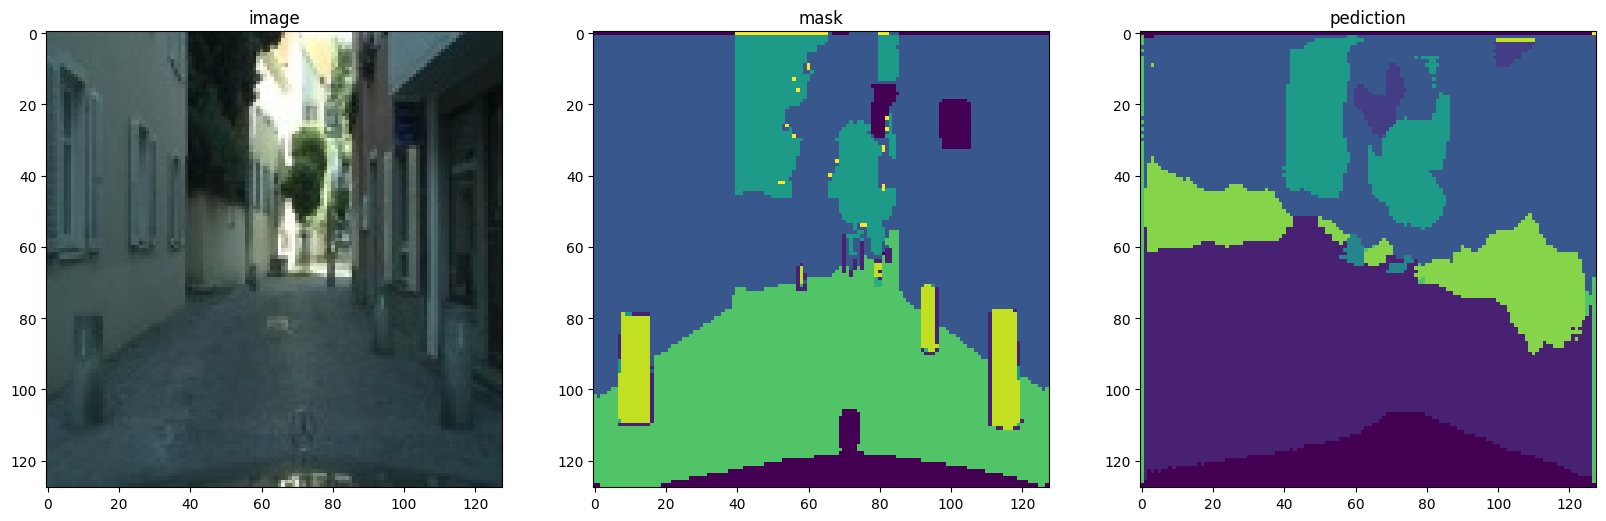

 10%|█         | 1/10 [01:20<12:06, 80.72s/it]

[Epochs-1/10]:
[Train_loss:1.1601 | Train_acc:0.2445 | Val_loss:1.0104 | Val_acc:0.2895]
--------------------
Validation results after 2 epochs:


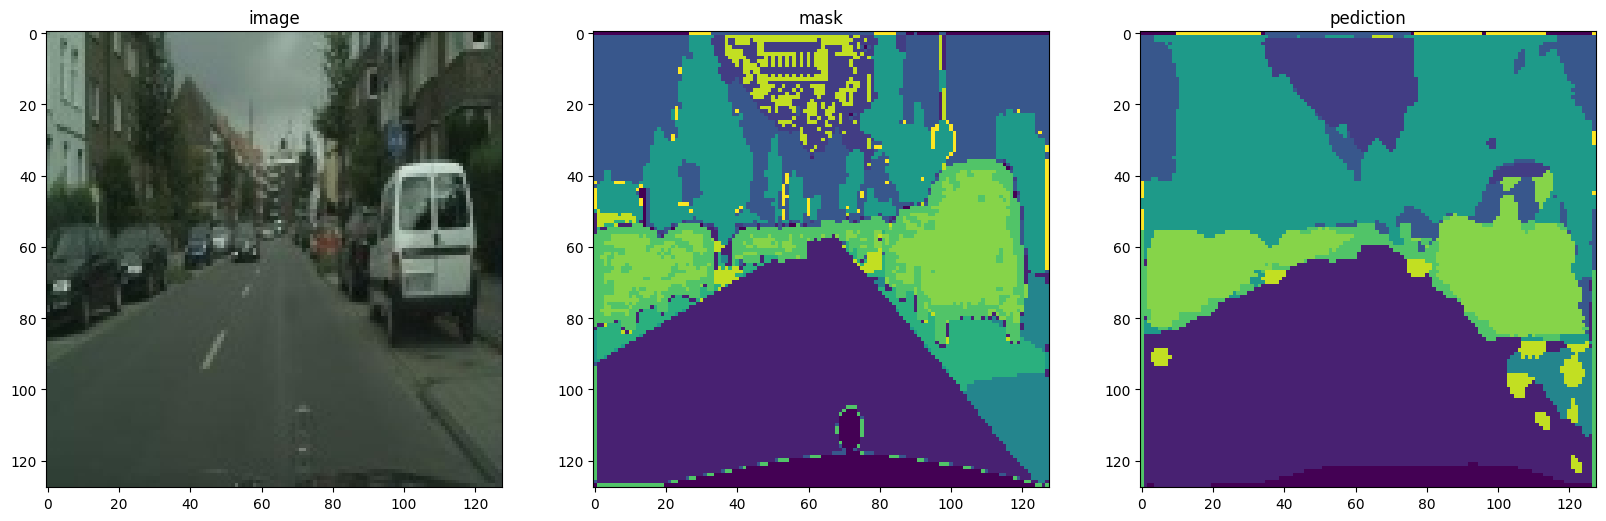

 20%|██        | 2/10 [02:36<10:23, 77.93s/it]

[Epochs-2/10]:
[Train_loss:0.9117 | Train_acc:0.3240 | Val_loss:1.0475 | Val_acc:0.2852]
--------------------
Validation results after 3 epochs:


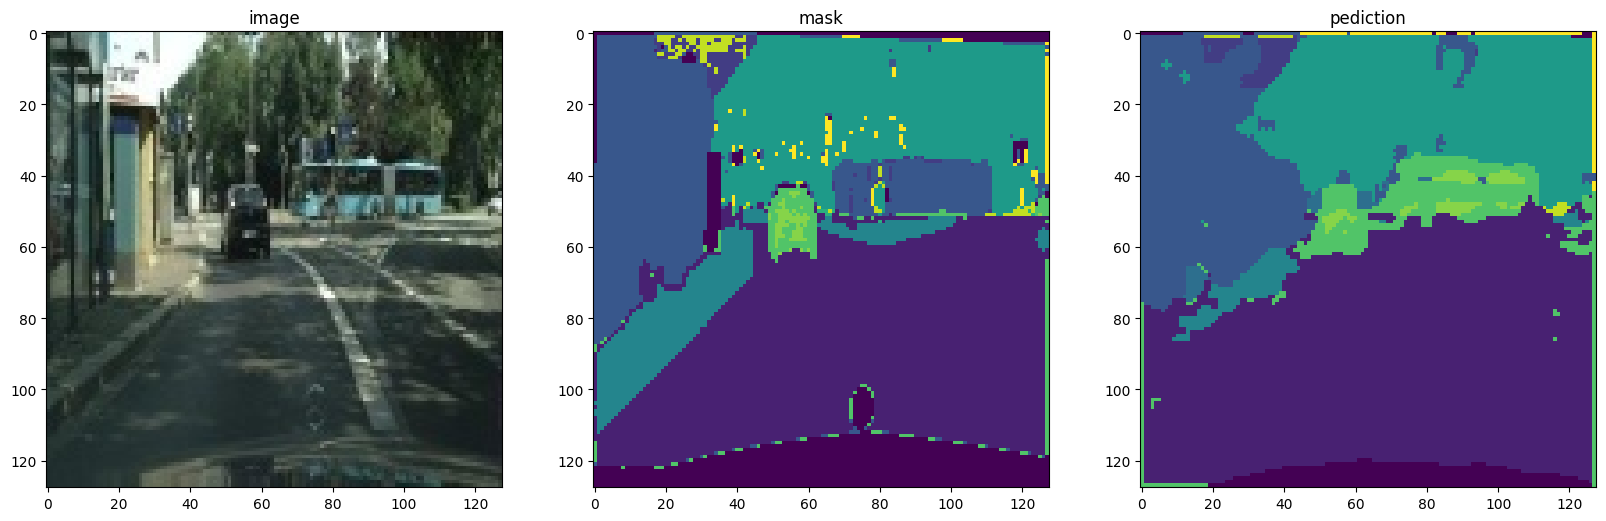

 30%|███       | 3/10 [03:52<08:57, 76.76s/it]

[Epochs-3/10]:
[Train_loss:0.8199 | Train_acc:0.3650 | Val_loss:2.9803 | Val_acc:0.3597]
--------------------
Validation results after 4 epochs:


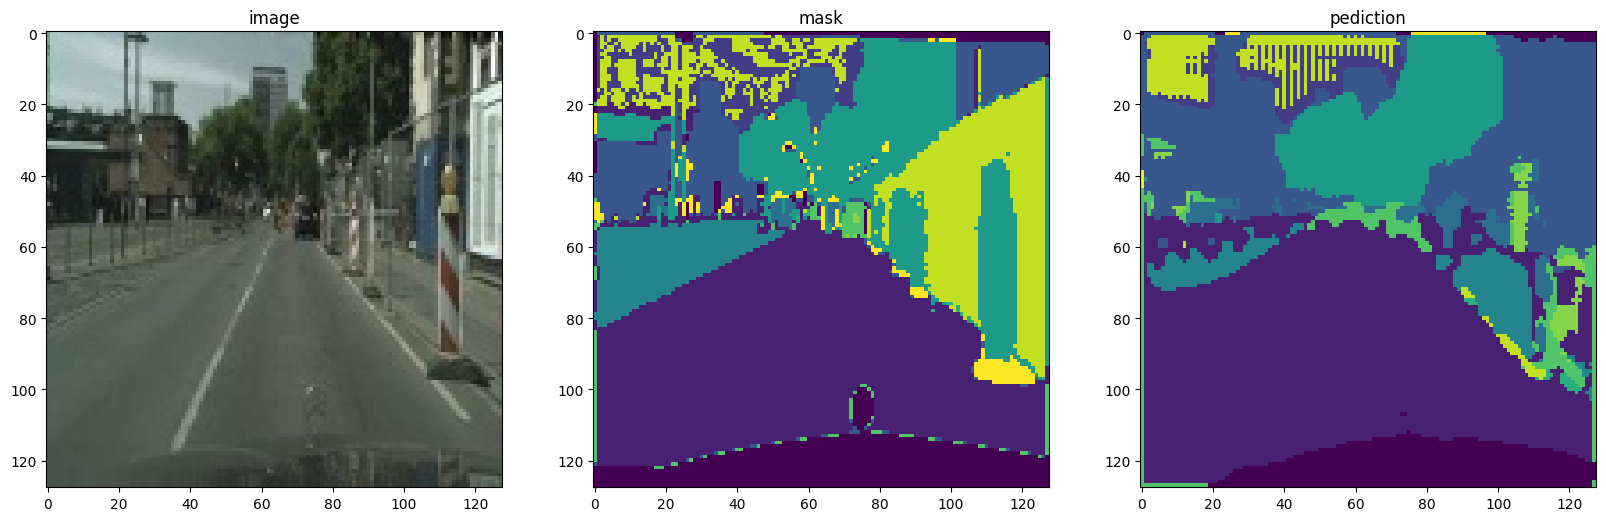

 40%|████      | 4/10 [05:07<07:36, 76.06s/it]

[Epochs-4/10]:
[Train_loss:0.7625 | Train_acc:0.3954 | Val_loss:1.3095 | Val_acc:0.3626]
--------------------
Validation results after 5 epochs:


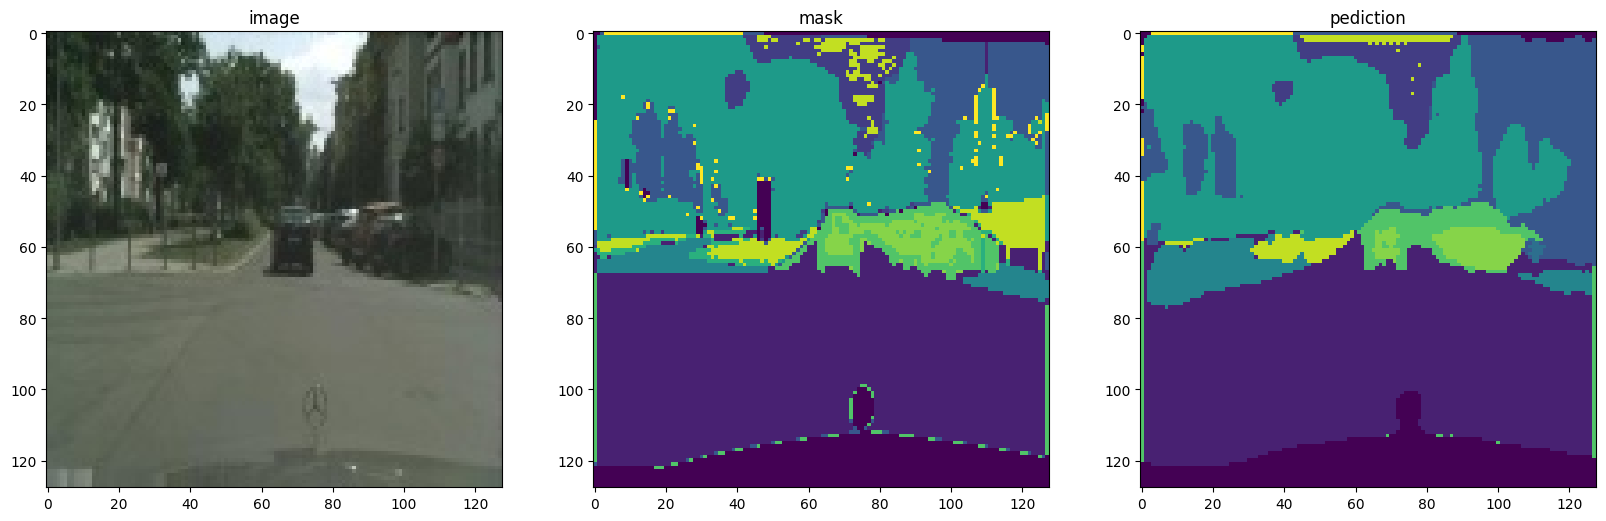

 50%|█████     | 5/10 [06:21<06:17, 75.51s/it]

[Epochs-5/10]:
[Train_loss:0.6644 | Train_acc:0.4407 | Val_loss:1.0591 | Val_acc:0.4310]
--------------------
Validation results after 6 epochs:


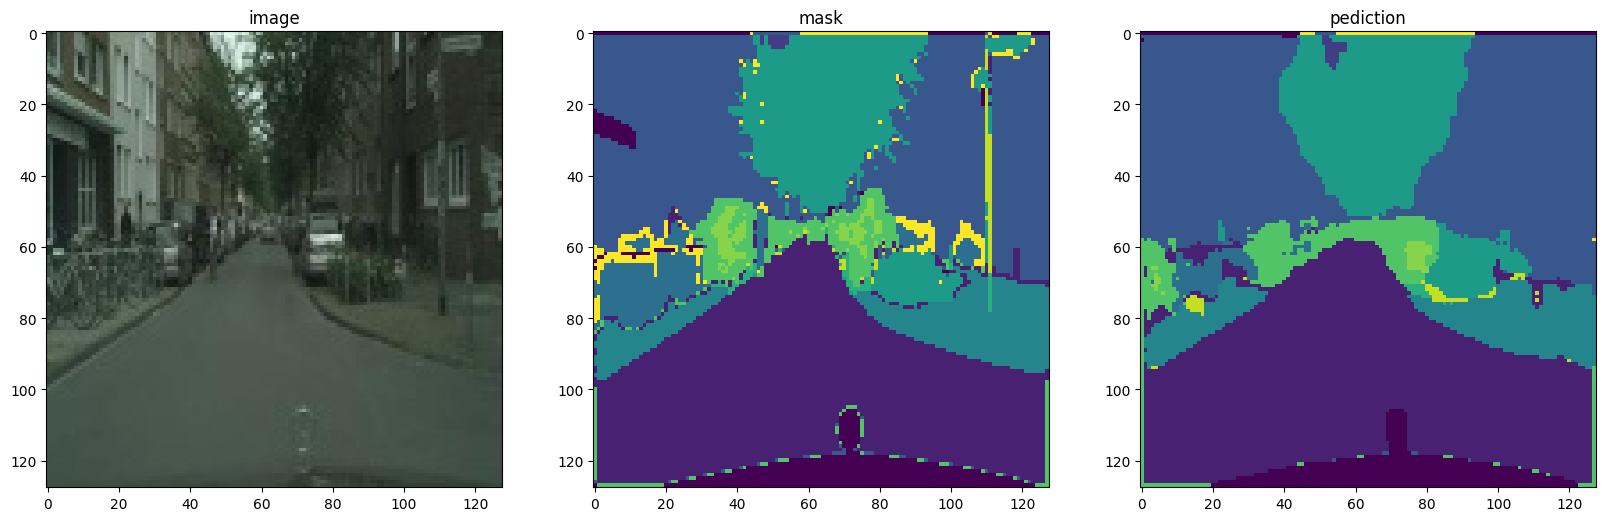

 60%|██████    | 6/10 [07:36<05:00, 75.14s/it]

[Epochs-6/10]:
[Train_loss:0.6459 | Train_acc:0.4496 | Val_loss:0.6632 | Val_acc:0.4398]
--------------------
Validation results after 7 epochs:


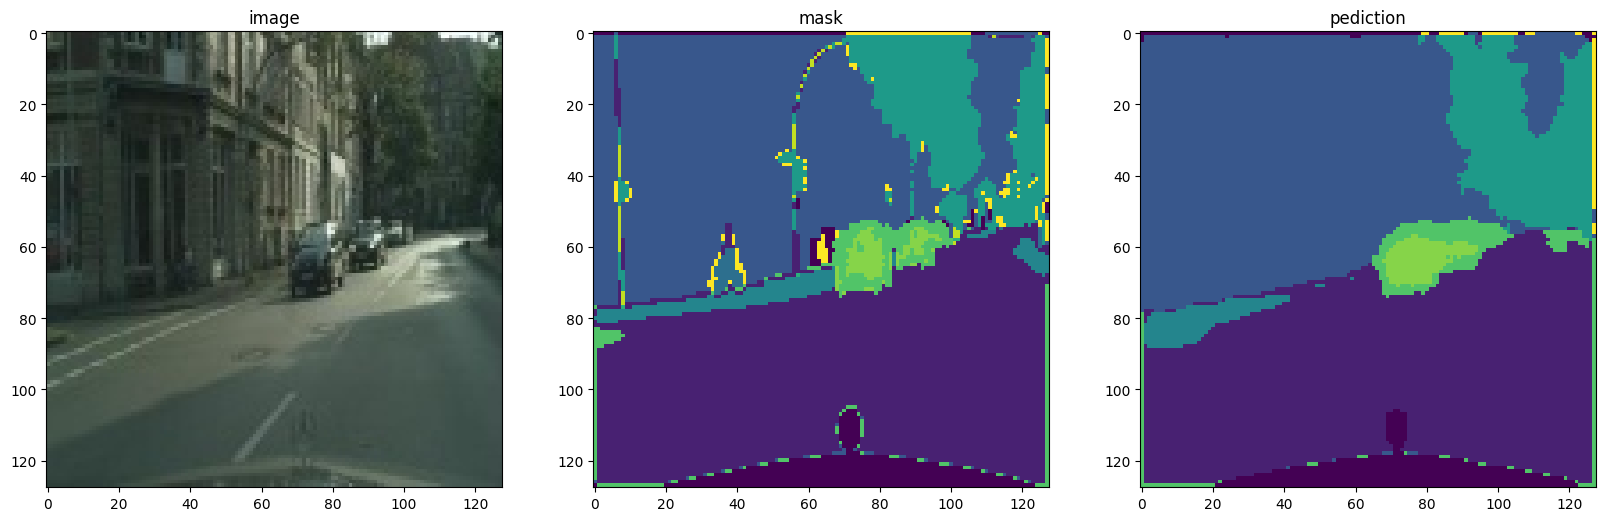

 70%|███████   | 7/10 [08:50<03:44, 74.87s/it]

[Epochs-7/10]:
[Train_loss:0.6335 | Train_acc:0.4557 | Val_loss:1.2827 | Val_acc:0.4433]
--------------------
Validation results after 8 epochs:


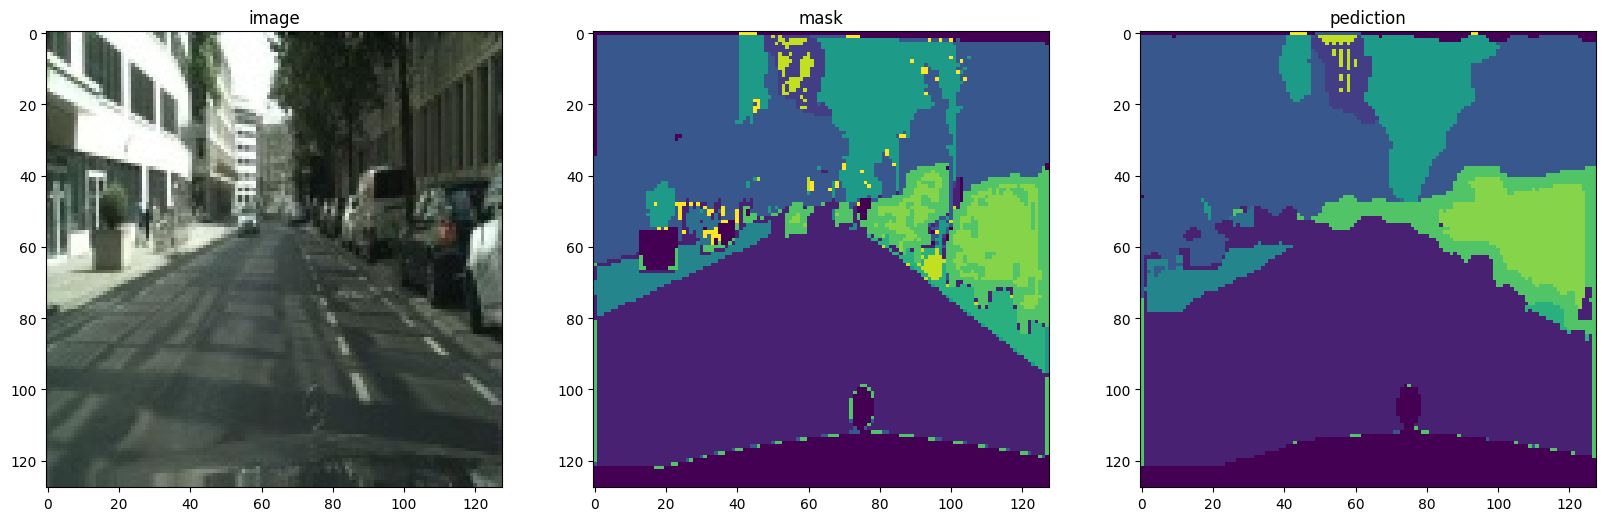

 80%|████████  | 8/10 [10:04<02:29, 74.74s/it]

[Epochs-8/10]:
[Train_loss:0.6192 | Train_acc:0.4637 | Val_loss:443.7347 | Val_acc:0.4403]
--------------------
Validation results after 9 epochs:


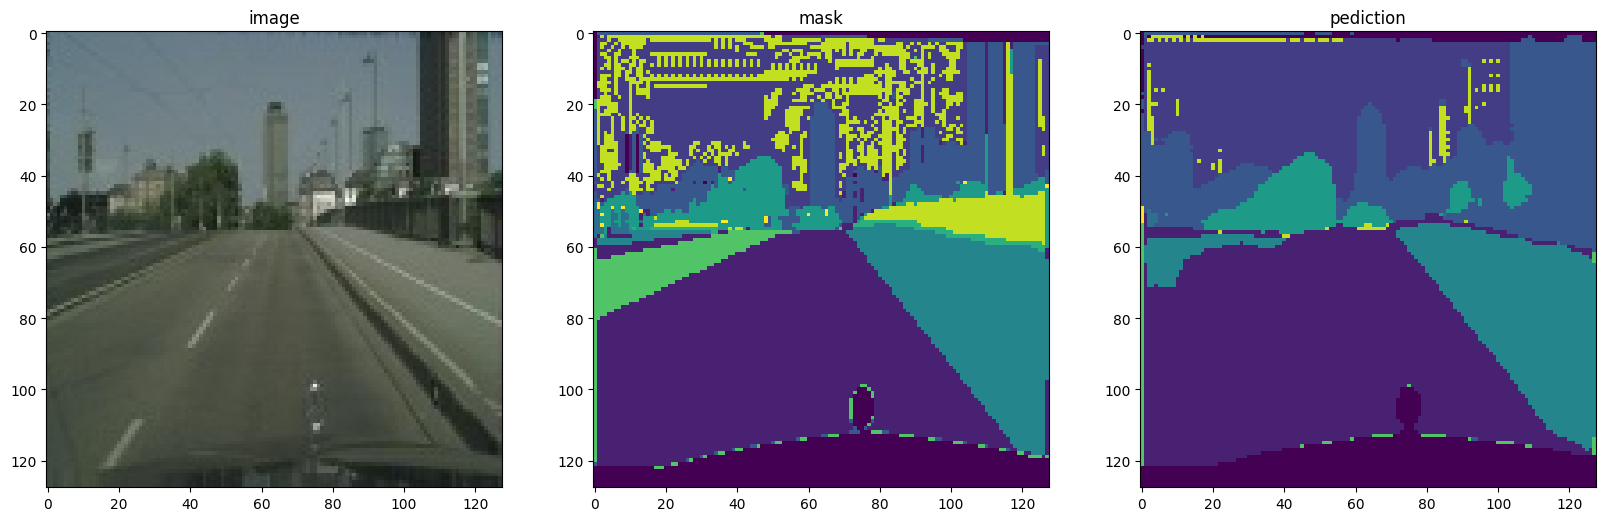

 90%|█████████ | 9/10 [11:19<01:14, 74.65s/it]

[Epochs-9/10]:
[Train_loss:0.6048 | Train_acc:0.4693 | Val_loss:0.6996 | Val_acc:0.4529]
--------------------
Validation results after 10 epochs:


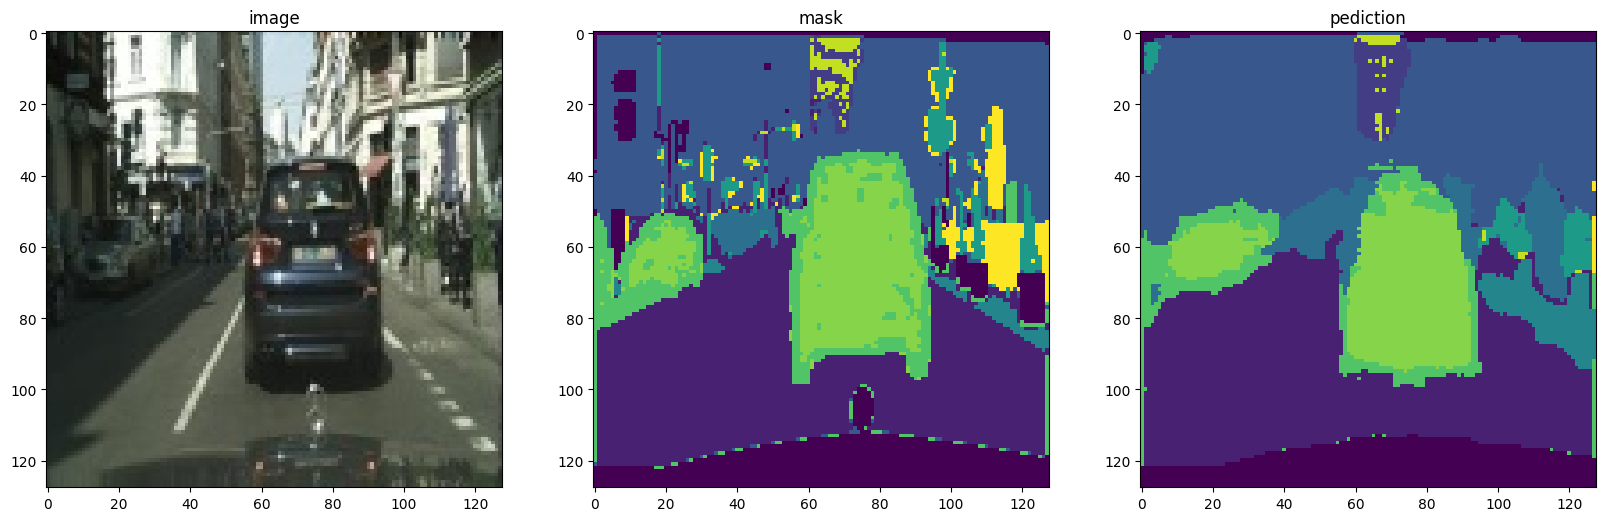

100%|██████████| 10/10 [12:33<00:00, 75.37s/it]

[Epochs-10/10]:
[Train_loss:0.5994 | Train_acc:0.4719 | Val_loss:0.7909 | Val_acc:0.4546]


In [ ]:
trainer.train()

# Exercise
- Repeat the experiment with image and mask size 64 x 64 and check the effect on validation acc
- Repeat the experiment after removing the contracting_31, contracting_32, expansive_31, expansive_32 layers of the network and check the effect on validation acc


## With Image size = 64

In [ ]:
class Dataset_64(Dataset):
    def __init__(self, images_list,mask_list, size, augmentation = False, mean = None, std = None):
        self.images_list = images_list
        self.mask_list = mask_list
        self.size = size
        self.augmentation = augmentation
        if mean is None or std is None:
            self.mean = [0., 0., 0.]
            self.std = [1., 1., 1.]
        else:
            self.mean = mean
            self.std = std

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, index):
        newsize = (64, 64)

        pil_image = Image.open(self.images_list[index]).convert('RGB').resize(newsize)
        pil_mask = Image.open(self.mask_list[index]).convert('RGB').resize(newsize)



        np_image = np.array(pil_image)
        np_target = np.array(pil_mask)


        test = (np_target.reshape(-1,3))
        pred = encoder.predict(test)
        seg_msk = pred.reshape(self.size,self.size)

        if self.augmentation:
            trans_obj = A.Compose([A.Resize(self.size, self.size),
                           A.Rotate(10, border_mode=4, p=0.5),
                           A.HorizontalFlip(p=0.3),
                           A.VerticalFlip(p=0.3),
                           A.OneOf([A.OpticalDistortion(),A.ElasticTransform()],  p=0.4),
                           A.CoarseDropout(max_holes=30, max_height=int(self.size*0.015),
                                         max_width=int(self.size*0.015), fill_value=255, p=0.4),
                           A.RandomBrightnessContrast(brightness_limit=0.3,p = 0.4),
                           A.RandomSnow(snow_point_lower=0.4,snow_point_upper=0.5,brightness_coeff=1.5,p = 0.4),
                           A.Normalize(self.mean, self.std)
                          ])
        else:
            trans_obj = A.Compose([A.Resize(self.size, self.size),
                                   A.Normalize(self.mean, self.std)])

        transformed = trans_obj(image = np_image, mask = seg_msk)
        img_tensor = from_numpy(transformed['image']).permute(2, 0, 1)
        mask_tensor = from_numpy(transformed['mask'])
        return img_tensor, mask_tensor


In [ ]:
train_data_obj_64 = Dataset_64(train_files,train_files_mask, 64, AUGMENTATION, mean=MEAN, std=STD)
val_data_obj_64 = Dataset_64(test_files, test_files_mask, 64, AUGMENTATION, mean=MEAN, std=STD)

In [ ]:
print(train_data_obj_64.__len__())
print(val_data_obj_64.__len__())

2975
500


In [ ]:
unet_new = Net(num_classes=OUTPUT_CLASSES)

In [ ]:
print(sum(p.numel() for p in unet.parameters()))

18010252


In [ ]:
tr_new =  Trainer(model = unet_new,
                  crit = loss_function,
                  train_data = train_data_obj_64,
                  val_data = val_data_obj_64,
                  initialize_from_ckp = None,
                  opti_name = OPIMIZER_NAME,
                  scheduler_name = SCHEDULER_NAME,
                  input_img_size = 64,
                  batch_size = BATCH_SIZE,
                  out_classes = OUTPUT_CLASSES,
                  use_cuda = USE_CUDA,
                  max_epochs = MAX_EPOCHS,
                  learning_rate = LEARINING_RATE,
                  thresh_acc = THRESH_ACC_CKP,
                  step_size = SCHEDULER_STEP_SIZE
                 )

  0%|          | 0/10 [00:00<?, ?it/s]

--------------------
Validation results after 1 epochs:


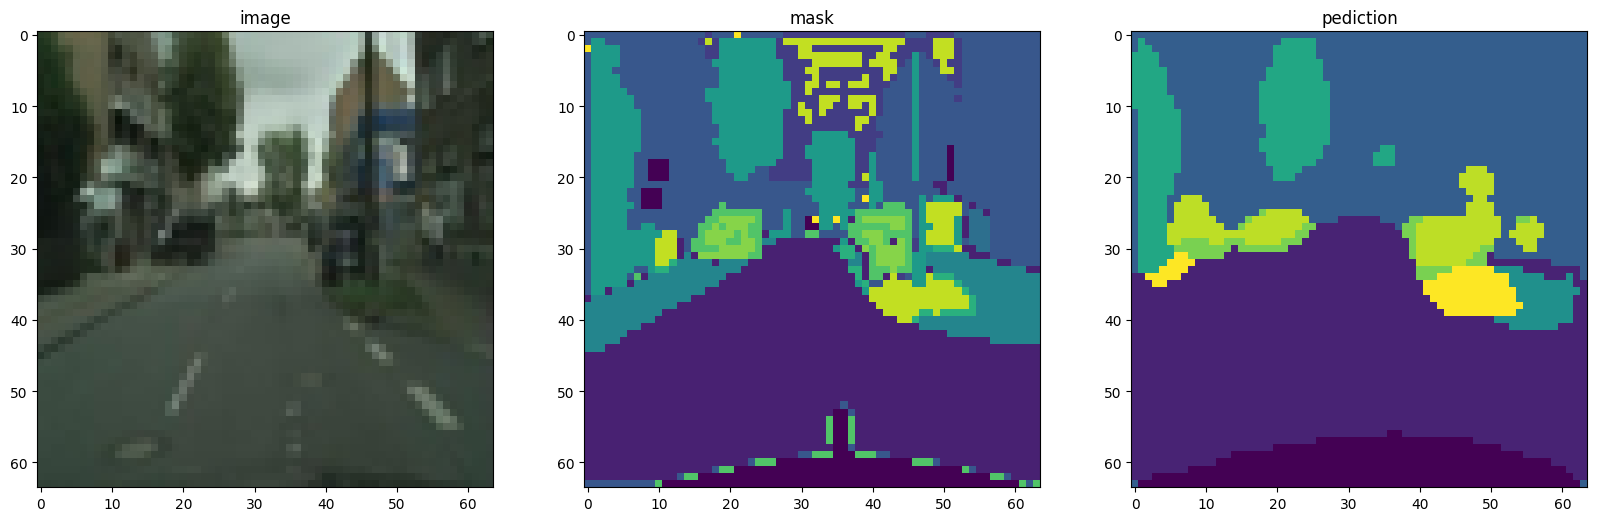

 10%|█         | 1/10 [00:29<04:21, 29.10s/it]

[Epochs-1/10]:
[Train_loss:1.0934 | Train_acc:0.2493 | Val_loss:1.0494 | Val_acc:0.2561]
--------------------
Validation results after 2 epochs:


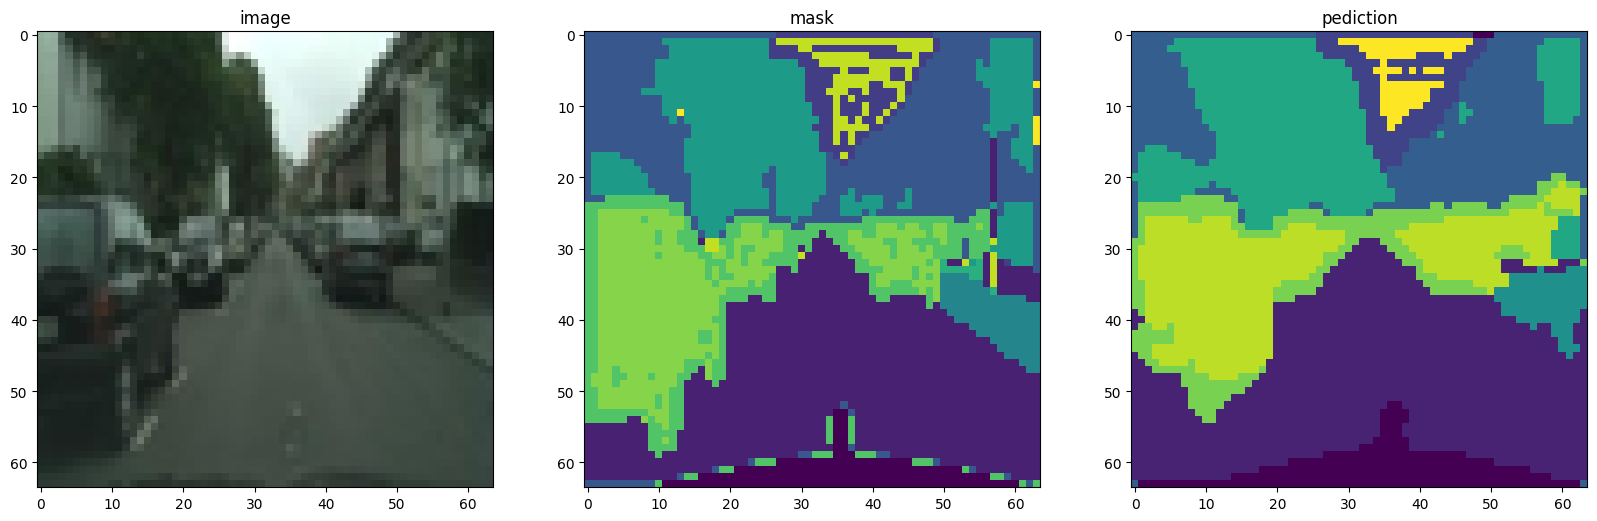

 20%|██        | 2/10 [00:57<03:51, 28.90s/it]

[Epochs-2/10]:
[Train_loss:0.8708 | Train_acc:0.3187 | Val_loss:0.9457 | Val_acc:0.3046]
--------------------
Validation results after 3 epochs:


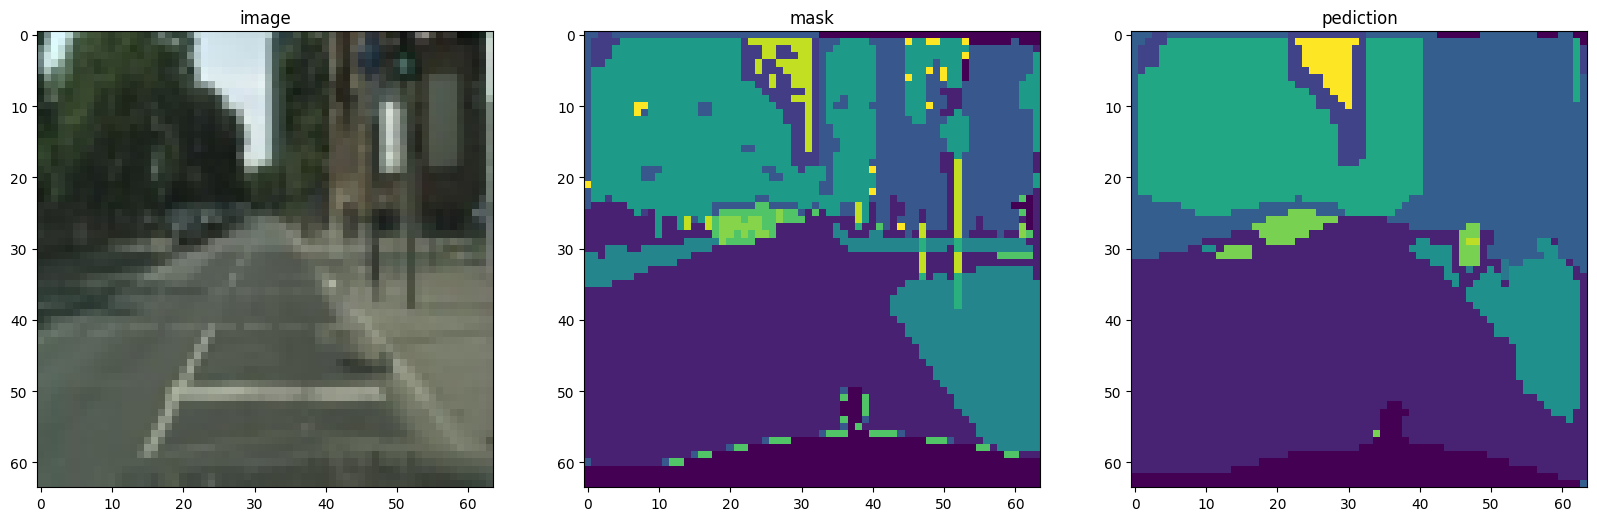

 30%|███       | 3/10 [01:28<03:27, 29.60s/it]

[Epochs-3/10]:
[Train_loss:0.8174 | Train_acc:0.3420 | Val_loss:0.8382 | Val_acc:0.3320]
--------------------
Validation results after 4 epochs:


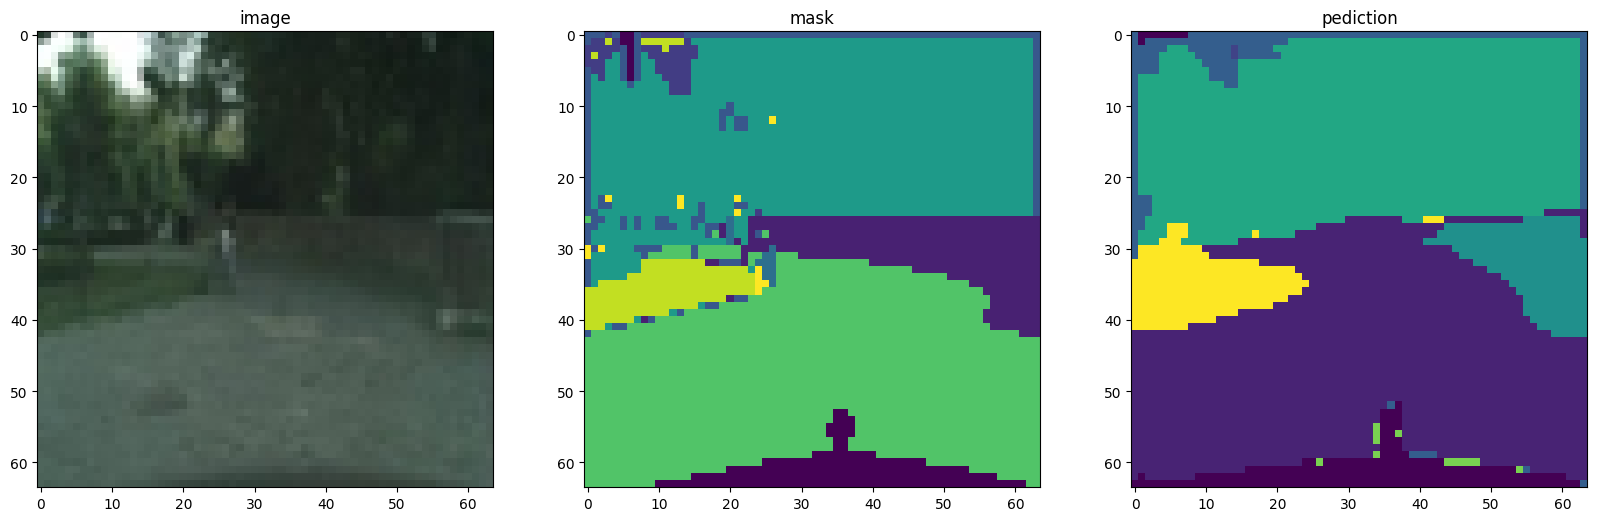

 40%|████      | 4/10 [02:00<03:03, 30.63s/it]

[Epochs-4/10]:
[Train_loss:0.7627 | Train_acc:0.3698 | Val_loss:0.8663 | Val_acc:0.3269]
--------------------
Validation results after 5 epochs:


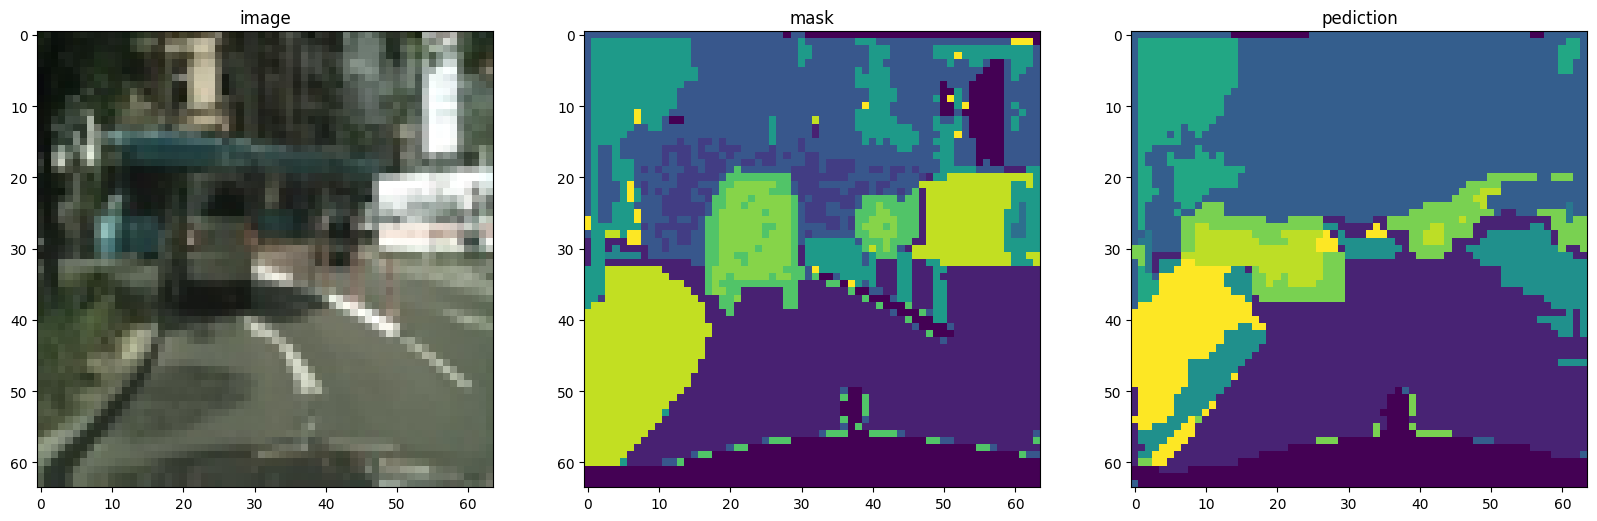

 50%|█████     | 5/10 [02:39<02:47, 33.57s/it]

[Epochs-5/10]:
[Train_loss:0.6761 | Train_acc:0.4097 | Val_loss:781.9043 | Val_acc:0.4014]
--------------------
Validation results after 6 epochs:


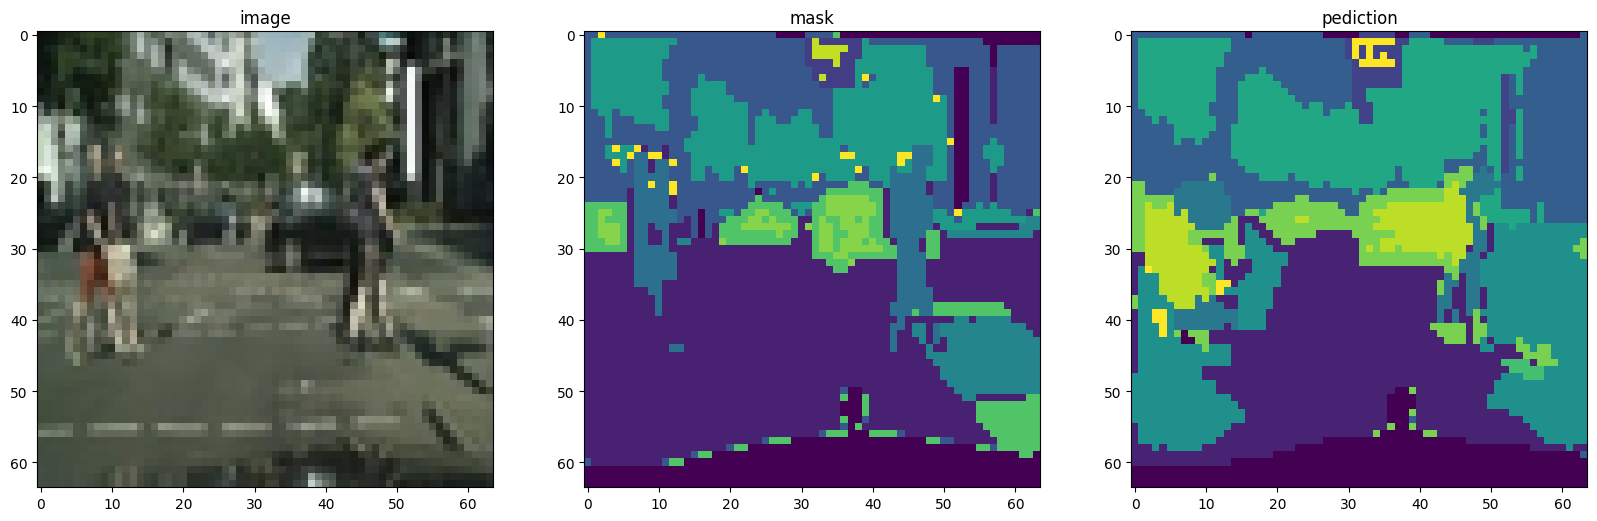

 60%|██████    | 6/10 [03:13<02:15, 33.90s/it]

[Epochs-6/10]:
[Train_loss:0.6579 | Train_acc:0.4209 | Val_loss:1.2175 | Val_acc:0.4078]
--------------------
Validation results after 7 epochs:


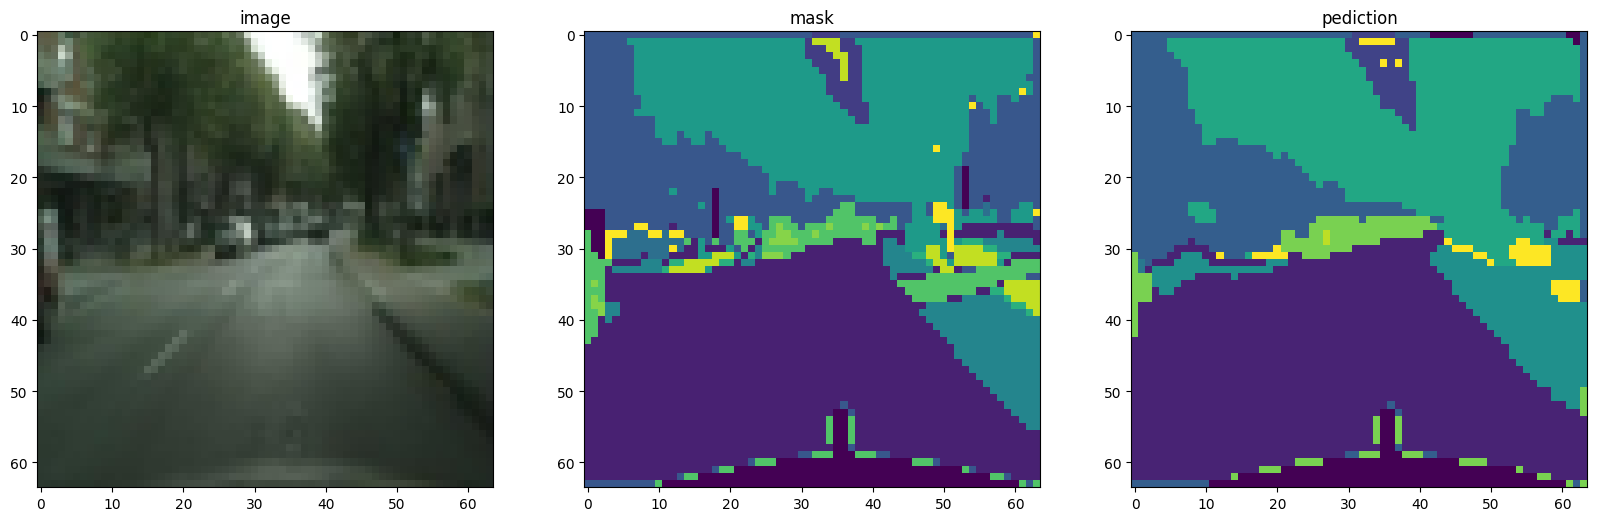

 70%|███████   | 7/10 [03:51<01:44, 34.98s/it]

[Epochs-7/10]:
[Train_loss:0.6439 | Train_acc:0.4283 | Val_loss:0.6701 | Val_acc:0.4156]
--------------------
Validation results after 8 epochs:


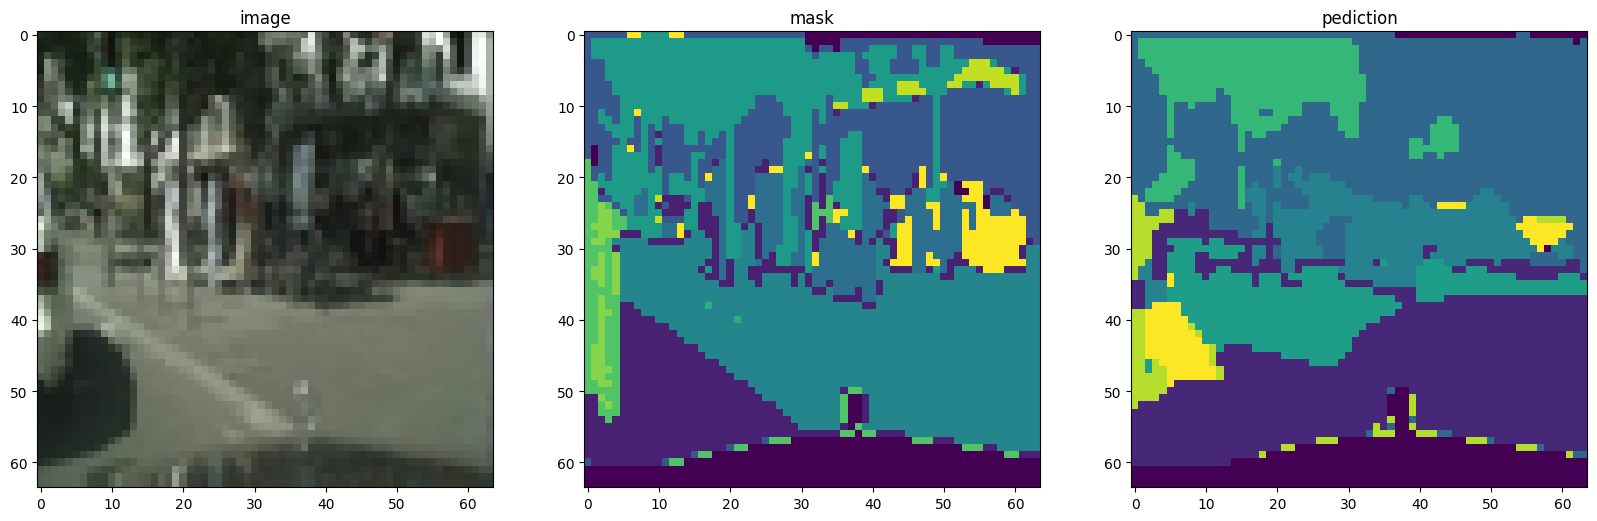

 80%|████████  | 8/10 [04:24<01:09, 34.50s/it]

[Epochs-8/10]:
[Train_loss:0.6300 | Train_acc:0.4355 | Val_loss:1.3947 | Val_acc:0.4240]
--------------------
Validation results after 9 epochs:


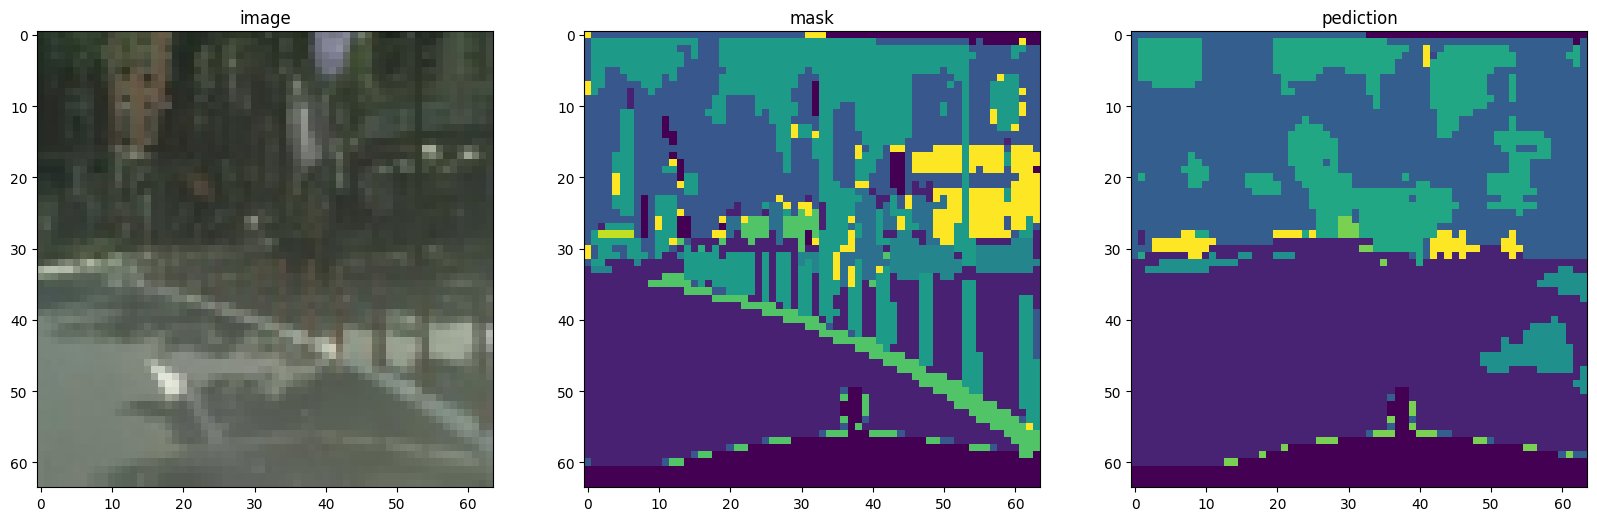

 90%|█████████ | 9/10 [04:54<00:32, 32.98s/it]

[Epochs-9/10]:
[Train_loss:0.6075 | Train_acc:0.4460 | Val_loss:3.7935 | Val_acc:0.4293]
--------------------
Validation results after 10 epochs:


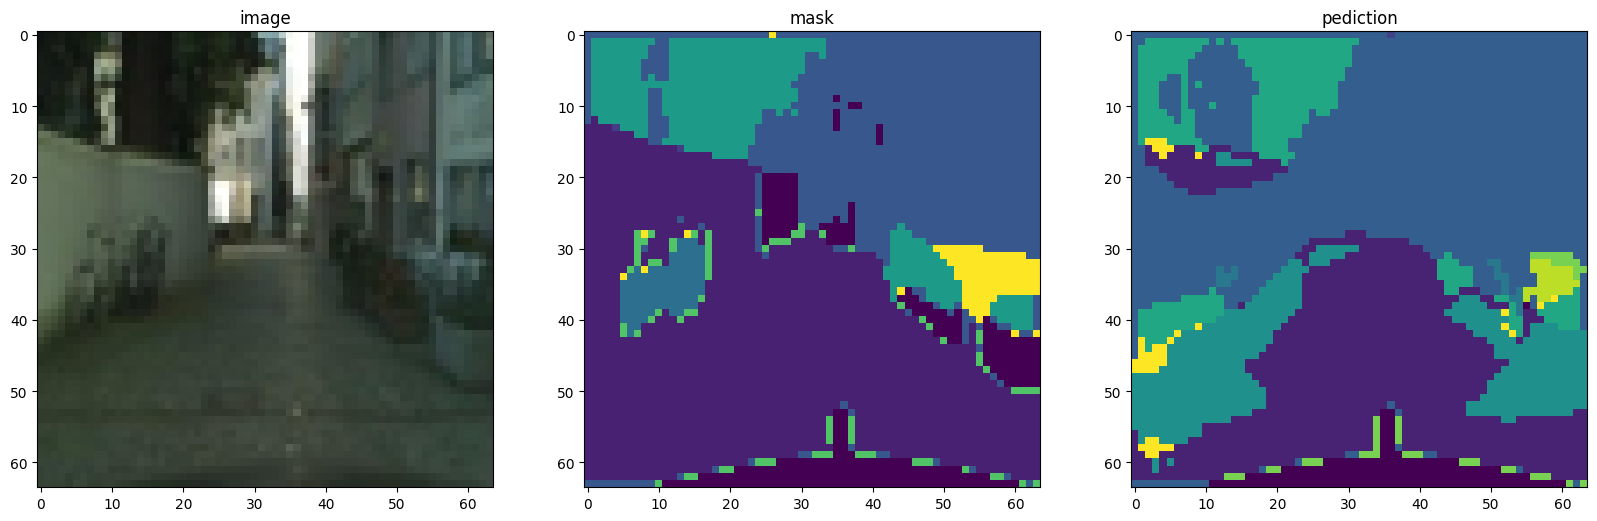

100%|██████████| 10/10 [05:23<00:00, 32.38s/it]

[Epochs-10/10]:
[Train_loss:0.6020 | Train_acc:0.4488 | Val_loss:0.6455 | Val_acc:0.4285]


In [ ]:
tr_new.train()

**Original model results:** [Train_loss:0.5994 | Train_acc:0.4719 | Val_loss:0.7909 | Val_acc:0.4546]<br>
**New model (64x64) results:**[Train_loss:0.6020 | Train_acc:0.4488 | Val_loss:0.6455 | Val_acc:0.4285]
<br>
We can see that accuracy has decreased a bit, this is due to the lesser information in the 64x64 images and the smaller cluster formation from k means.

## With removed layers of network

In [ ]:
class Net_new(nn.Module):
    def __init__(self, num_classes):
        super(Net_new, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.middle = self.conv_block(in_channels=128, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=128, out_channels=64)

        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)




    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):

        contracting_11_out = self.contracting_11(X)

        contracting_12_out = self.contracting_12(contracting_11_out)

        contracting_21_out = self.contracting_21(contracting_12_out)

        contracting_22_out = self.contracting_22(contracting_21_out)


        middle_out = self.middle(contracting_22_out)

        expansive_11_out = self.expansive_11(middle_out)

        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_21_out), dim=1))

        expansive_21_out = self.expansive_21(expansive_12_out)

        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_11_out), dim=1))


        output_out = self.output(expansive_22_out)
        return output_out

In [ ]:
unet_rem= Net_new(num_classes=OUTPUT_CLASSES)

In [ ]:
print(sum(p.numel() for p in unet_rem.parameters()))

12698508


In [ ]:
tr_rem =  Trainer(model = unet_rem,
                  crit = loss_function,
                  train_data = train_data_obj,
                  val_data = val_data_obj,
                  initialize_from_ckp = None,
                  opti_name = OPIMIZER_NAME,
                  scheduler_name = SCHEDULER_NAME,
                  input_img_size = 128,
                  batch_size = BATCH_SIZE,
                  out_classes = OUTPUT_CLASSES,
                  use_cuda = USE_CUDA,
                  max_epochs = MAX_EPOCHS,
                  learning_rate = LEARINING_RATE,
                  thresh_acc = THRESH_ACC_CKP,
                  step_size = SCHEDULER_STEP_SIZE
                 )

  0%|          | 0/10 [00:00<?, ?it/s]

--------------------
Validation results after 1 epochs:


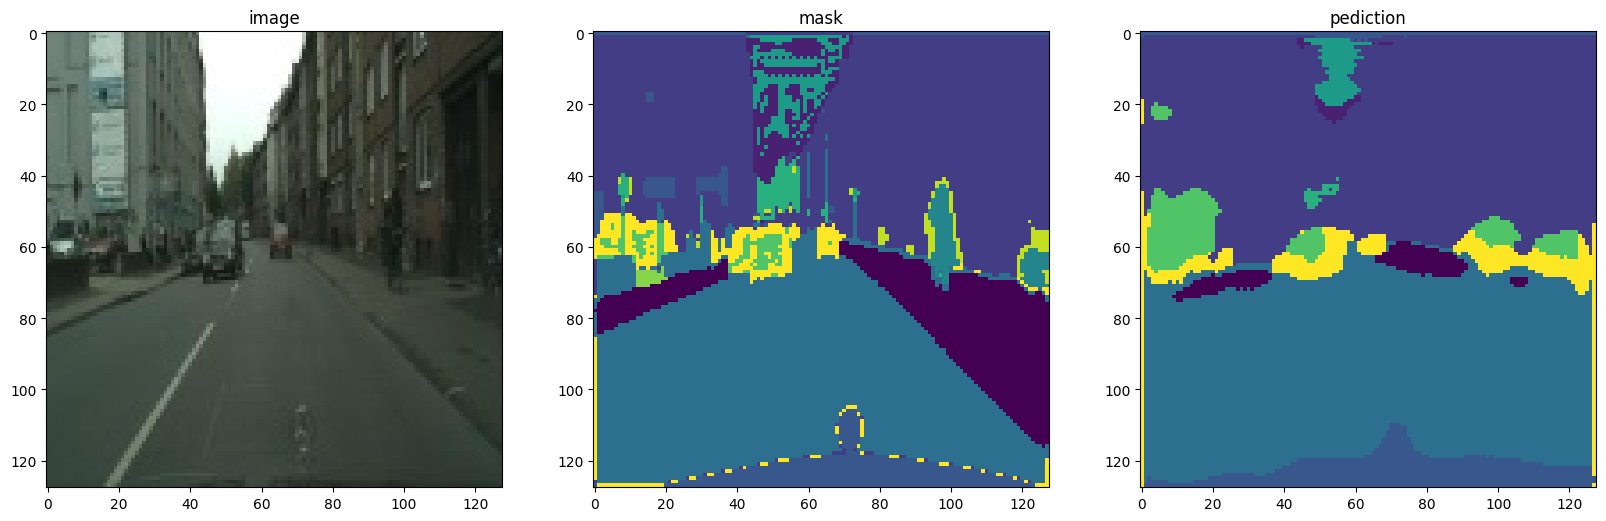

 10%|█         | 1/10 [01:30<13:31, 90.15s/it]

[Epochs-1/10]:
[Train_loss:1.1686 | Train_acc:0.2444 | Val_loss:1.0435 | Val_acc:0.2840]
--------------------
Validation results after 2 epochs:


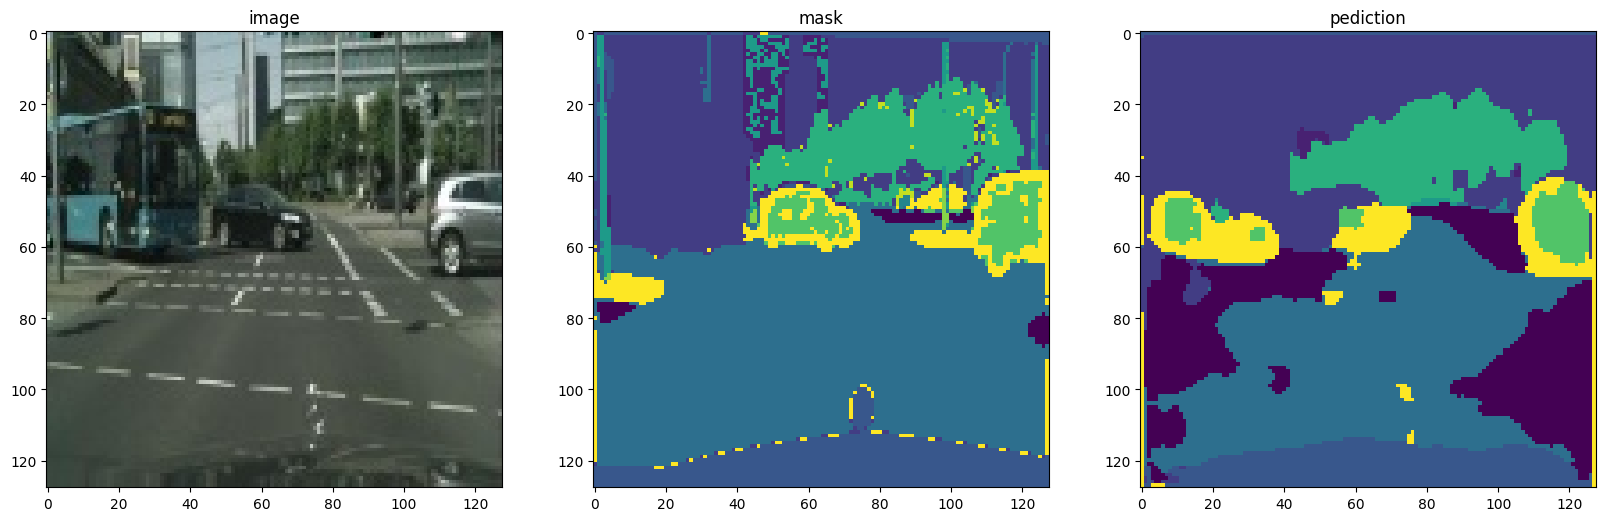

 20%|██        | 2/10 [02:51<11:21, 85.25s/it]

[Epochs-2/10]:
[Train_loss:0.8858 | Train_acc:0.3412 | Val_loss:1.1799 | Val_acc:0.2871]
--------------------
Validation results after 3 epochs:


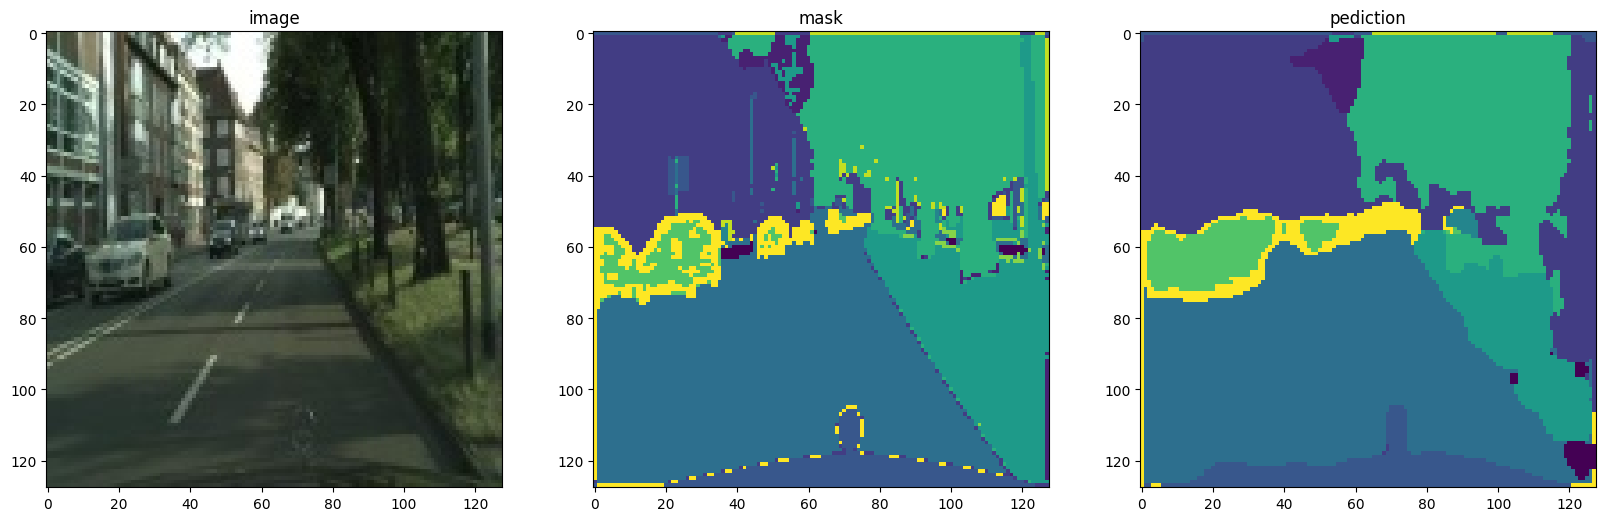

 30%|███       | 3/10 [04:16<09:53, 84.72s/it]

[Epochs-3/10]:
[Train_loss:0.7863 | Train_acc:0.3892 | Val_loss:0.7975 | Val_acc:0.3756]
--------------------
Validation results after 4 epochs:


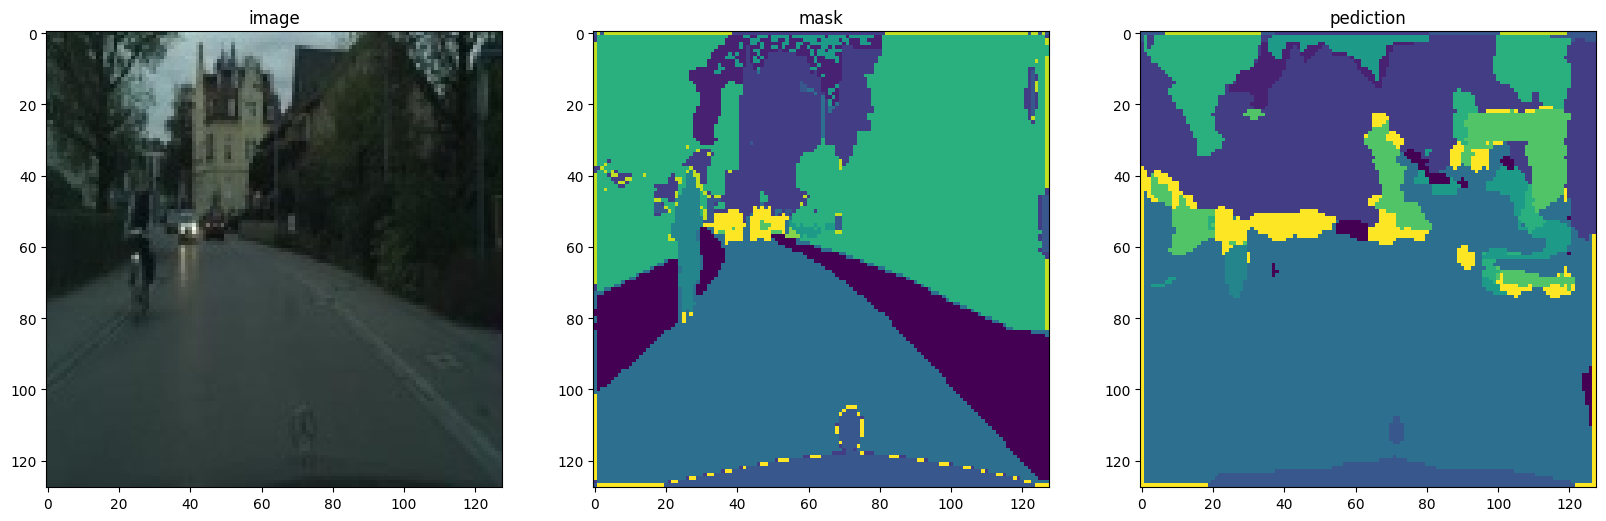

 40%|████      | 4/10 [05:37<08:20, 83.37s/it]

[Epochs-4/10]:
[Train_loss:0.7134 | Train_acc:0.4247 | Val_loss:0.9496 | Val_acc:0.3537]
--------------------
Validation results after 5 epochs:


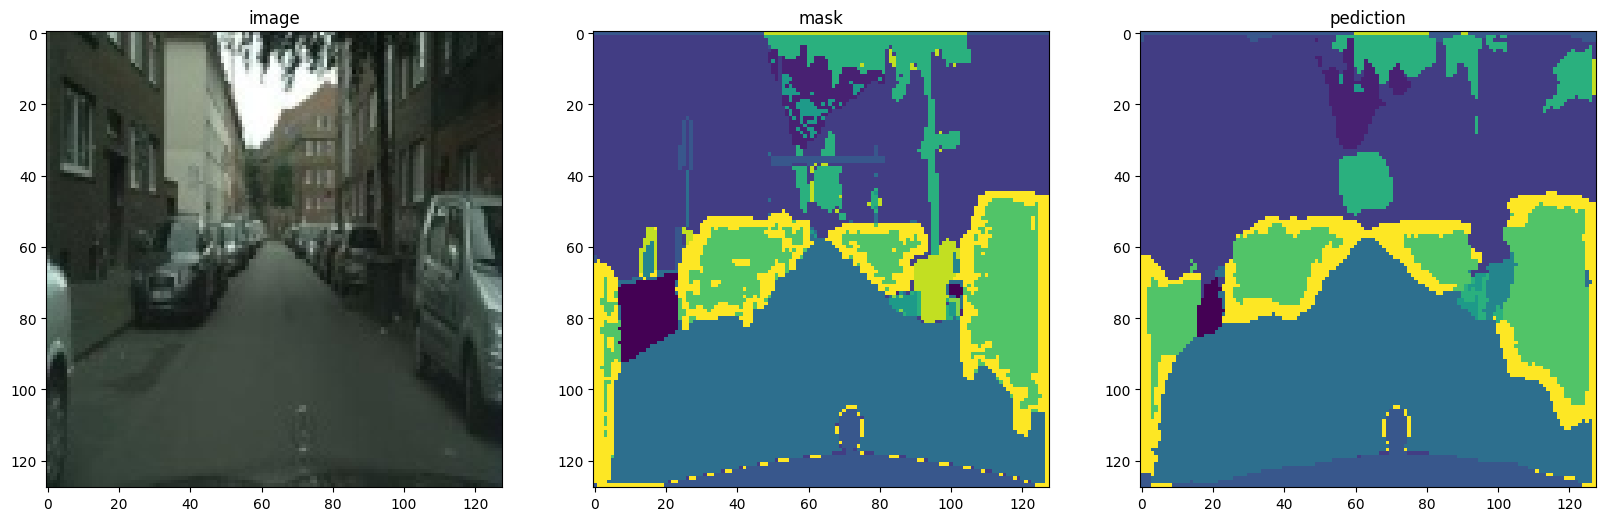

 50%|█████     | 5/10 [06:58<06:53, 82.71s/it]

[Epochs-5/10]:
[Train_loss:0.6361 | Train_acc:0.4607 | Val_loss:0.6425 | Val_acc:0.4482]
--------------------
Validation results after 6 epochs:


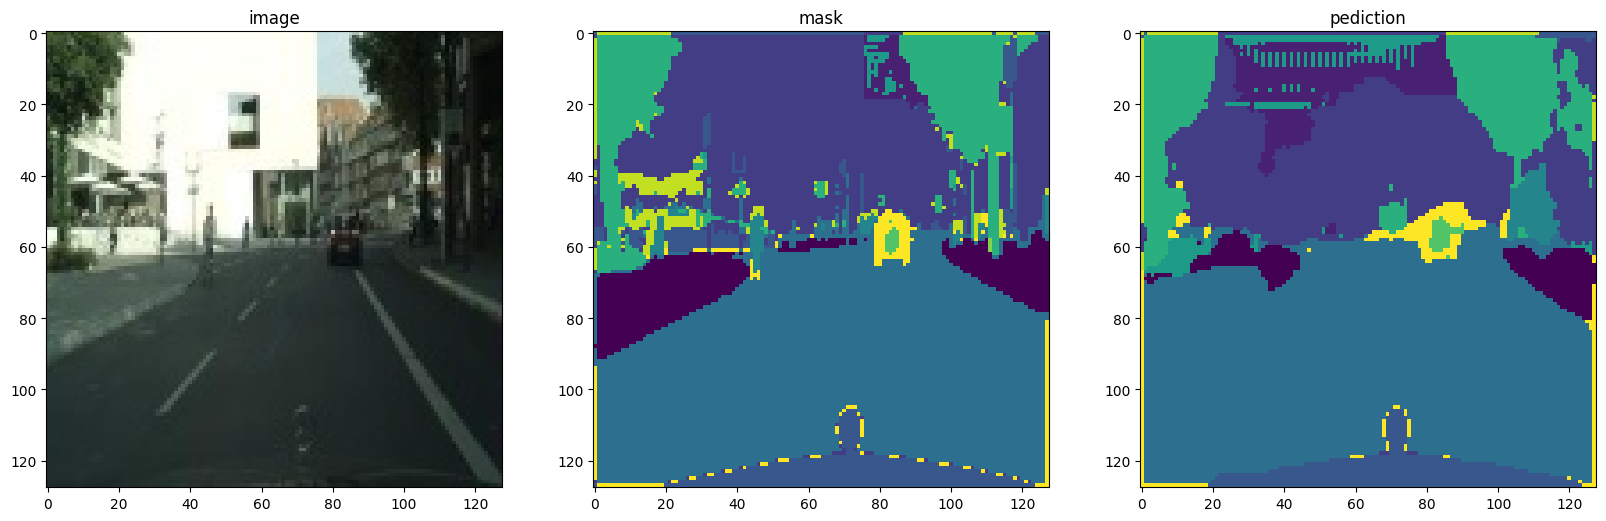

 60%|██████    | 6/10 [08:20<05:28, 82.17s/it]

[Epochs-6/10]:
[Train_loss:0.6176 | Train_acc:0.4684 | Val_loss:0.6341 | Val_acc:0.4548]
--------------------
Validation results after 7 epochs:


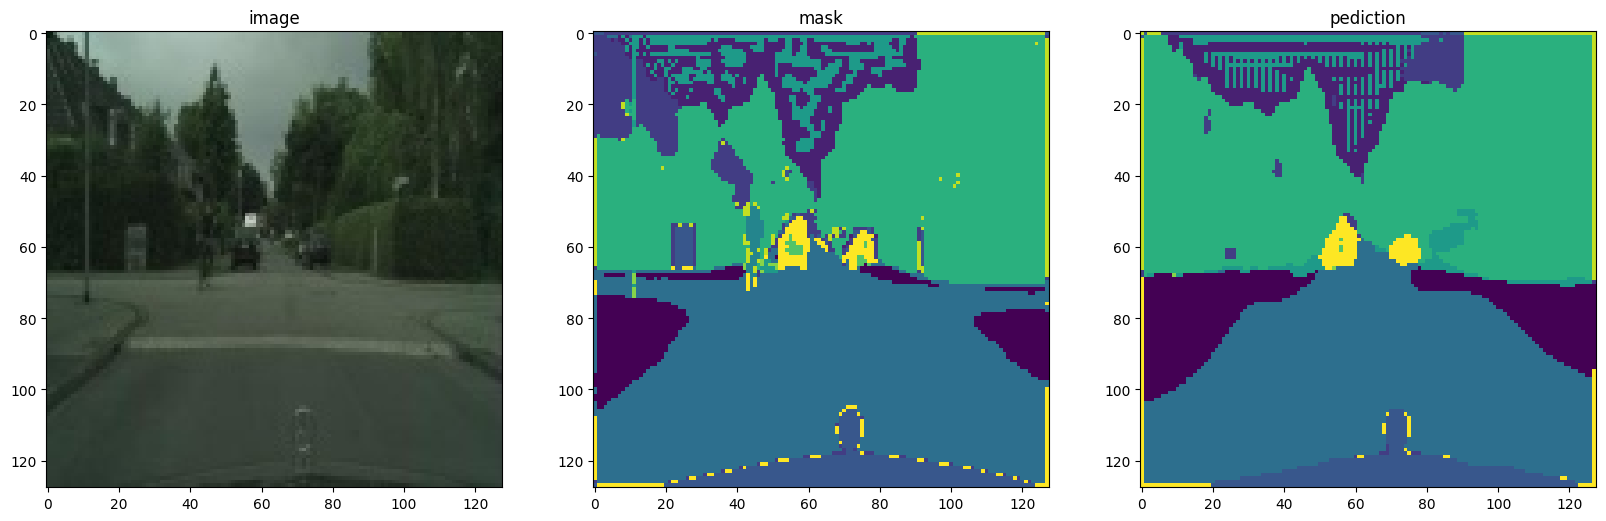

 70%|███████   | 7/10 [09:42<04:06, 82.18s/it]

[Epochs-7/10]:
[Train_loss:0.6041 | Train_acc:0.4760 | Val_loss:0.6301 | Val_acc:0.4551]
--------------------
Validation results after 8 epochs:


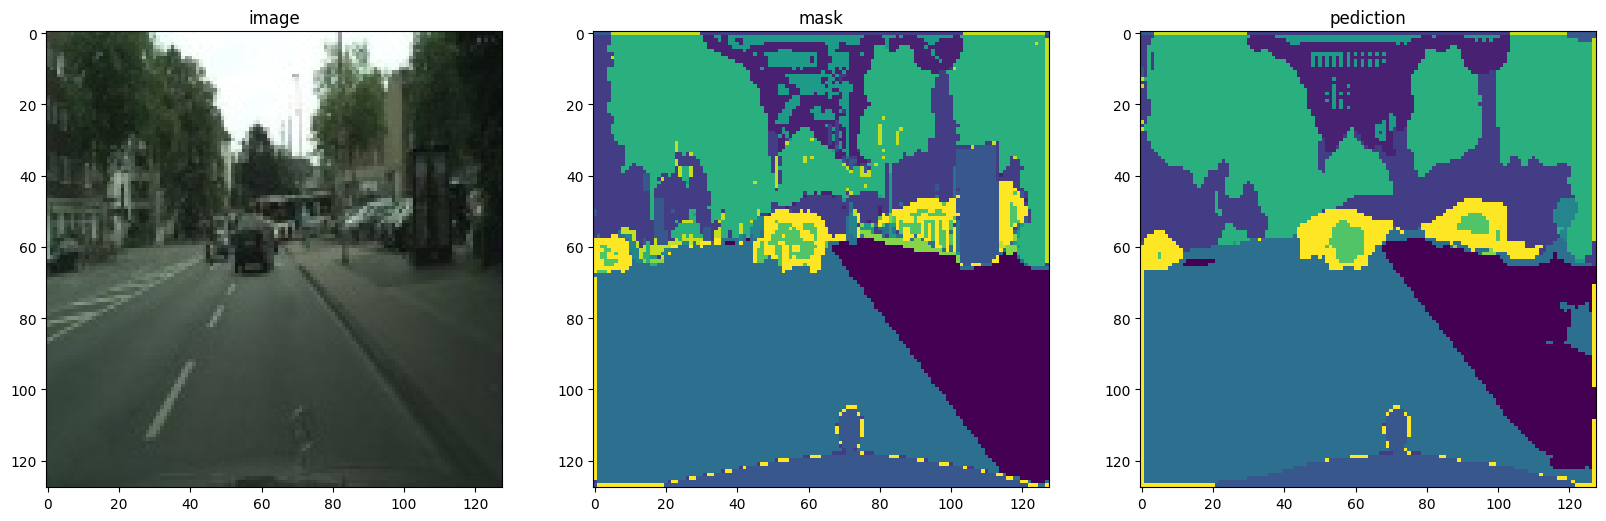

 80%|████████  | 8/10 [11:03<02:44, 82.04s/it]

[Epochs-8/10]:
[Train_loss:0.5956 | Train_acc:0.4811 | Val_loss:0.6186 | Val_acc:0.4609]
--------------------
Validation results after 9 epochs:


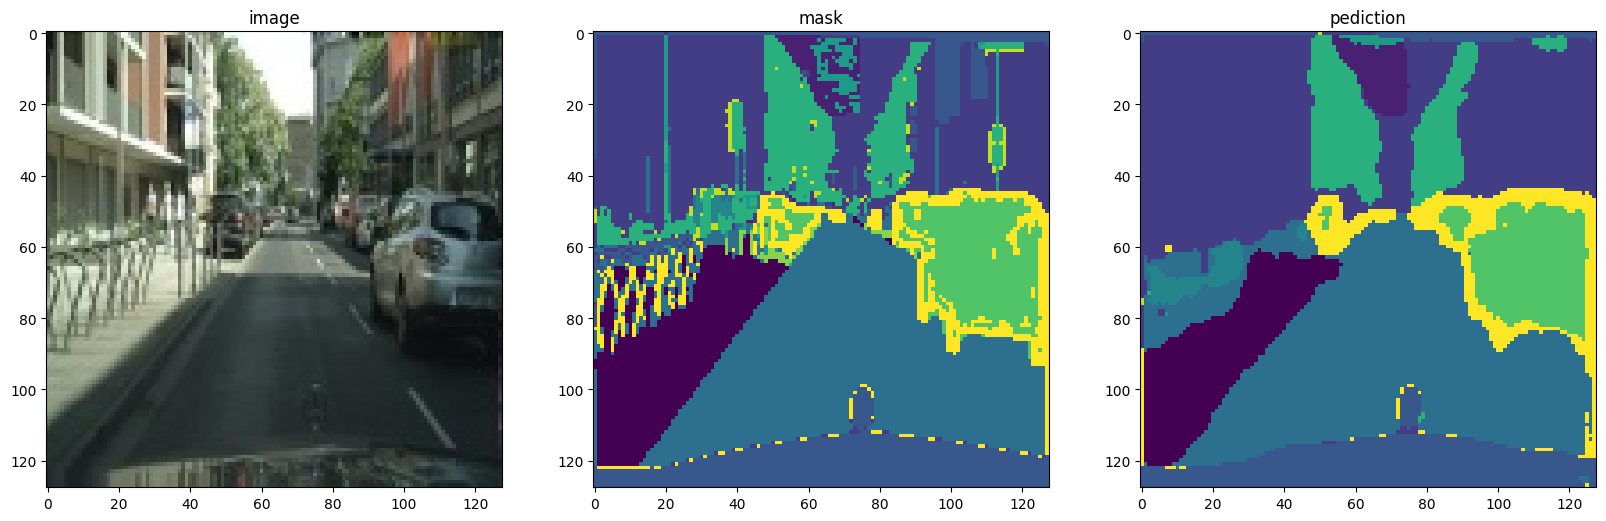

 90%|█████████ | 9/10 [12:25<01:21, 81.82s/it]

[Epochs-9/10]:
[Train_loss:0.5762 | Train_acc:0.4900 | Val_loss:0.6060 | Val_acc:0.4643]
--------------------
Validation results after 10 epochs:


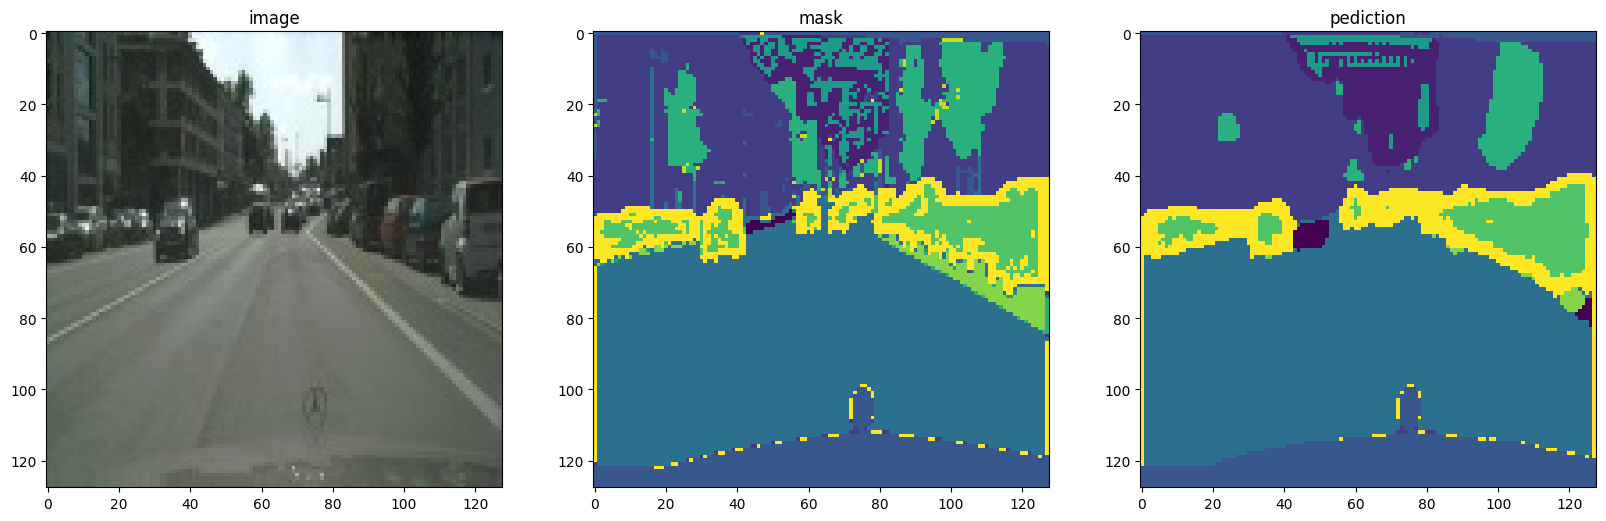

100%|██████████| 10/10 [13:47<00:00, 82.71s/it]

[Epochs-10/10]:
[Train_loss:0.5728 | Train_acc:0.4914 | Val_loss:0.6049 | Val_acc:0.4661]


In [ ]:
tr_rem.train()

**Original Results:** [Train_loss:0.5994 | Train_acc:0.4719 | Val_loss:0.7909 | Val_acc:0.4546]<br>
**New Results (Removed Layers):** [Train_loss:0.5728 | Train_acc:0.4914 | Val_loss:0.6049 | Val_acc:0.4661]
<br>
Here we've got similar accuracy tending towards the newer results because the change in dimensions in the conv layers tend towards the current model. While by decreasing the conv layers and having a smaller disparity is actually more suitable for the current dataset with 12 classes.